# DEEE0725 Project 1 - Speech Digit Recognition with HMM

## I. Import Necessary Libraries

In [154]:
import warnings
import os
from hmmlearn import hmm
import numpy as np
from librosa.feature import mfcc
import librosa
import random
import matplotlib.pyplot as plt
import scipy
import audioread
import IPython
import shutil
import pickle
import librosa.display

## II. Function Definition

#### 1. MFCC Feature Extraction Function

In [151]:
def extract_mfcc(full_audio_path):
    wave, sample_rate =  librosa.load(full_audio_path)
    mfcc_features = mfcc(wave, sample_rate, n_mfcc=20)
    return mfcc_features.T

#### 2. Dataloader Function for Segmented Data

In [129]:
def create_DataSet(path):    
    DataSet = {}
    folders = os.listdir(path)
    for label in range(10):
        DataSet[label] = []
        for folder in folders:
            if folder == '.DS_Store':
                folders.remove(folder)
                continue
            mfcclist = []
            newpath = path+folder+'/'+str(label)
            files = os.listdir(newpath)
            for file in files:
                if file.endswith('wav'):
                    mfcc = extract_mfcc(newpath+'/'+file)
                    mfcclist.append(mfcc)
            DataSet[label].extend(mfcclist)
    return DataSet

#### 3. HMM Model Training Function

In [130]:
def train_HMM(dataset):
    Models = {}
    for label in dataset.keys():
        model = hmm.GMMHMM(n_components=10)
        trainData = dataset[label]
        trData = np.vstack(trainData)
        model.fit(trData)
        Models[label] = model
    return Models

#### 4. HMM Model Evaluation Function

In [131]:
def predict(dataset, hmmModels):
        acc_count = 0
        all_data_count = 0
        for label in dataset.keys():
            feature = dataset[label]
            for index in range(len(feature)):
                all_data_count+=1
                scoreList = {}
                for model_label in hmmModels.keys():
                    model = hmmModels[model_label]
                    score = model.score(feature[index])
                    scoreList[model_label] = score
                predict = max(scoreList, key=scoreList.get)
                if predict == label:
                    acc_count+=1
    
        accuracy = round(((acc_count/all_data_count)*100.0),3)
        print("Accuracy: ", accuracy, "%")

#### 5. Test Dataset Segmentation

##### Intervalized Short-Time Energy derivative based Segmentation

In [161]:
def segment(signal, len_interval, printout=True):
    Fs = 16000
    data = signal

    frame_length = 160
    hop_length = 80
    n_frames = int(np.ceil(len(data)/hop_length))
    energy = np.zeros(n_frames)

    for i in range(n_frames):
        if i == 0:
            energy[i] = np.sum(data[i*hop_length:i*hop_length+frame_length]**2)
        else:
            energy[i] = np.sum(data[i*hop_length-frame_length:i*hop_length]**2)

    interval_size = len_interval
    num_intervals = int(np.ceil(len(energy)/interval_size))
    compressed_energy = np.zeros(num_intervals)
    for i in range(num_intervals):
        compressed_energy[i] = np.average(energy[i*interval_size:(i+1)*interval_size])
    comp_grad = np.gradient(compressed_energy)
    
    maxima = scipy.signal.argrelextrema(compressed_energy, np.greater)
    maxima_grad = scipy.signal.argrelextrema(comp_grad, np.greater)
    minima_grad = scipy.signal.argrelextrema(comp_grad, np.less)
    
    local_maxima = []
    for loc in maxima[0]:
        if compressed_energy[loc] < 0.1:
            continue
        if (comp_grad[loc-1]*comp_grad[loc+1] < 0):
            if comp_grad[loc-1] > 0:
                local_maxima.append(loc)
    
    local_maxima_energy = np.array(local_maxima)*interval_size + interval_size//2
    local_maxima_original = np.array(local_maxima)*interval_size*hop_length + interval_size*hop_length//2
    
    segments = []
    for i in range(len(local_maxima)):
        if len(local_maxima)>10:
            if compressed_energy[local_maxima[i]] < np.mean(compressed_energy[local_maxima])*0.4:
                continue
        start = local_maxima[i]
        count = 0
        while start not in maxima_grad[0]:
            start -= 1
            if start == 0:
                break
        end = local_maxima[i]
        if end > minima_grad[0][-1]:
            continue
        while end not in minima_grad[0]:
            end += 1
        segments.append([start, end])
    segments = np.array(segments)
    segments_energy = segments*interval_size + interval_size//2
    segments_original = segments_energy*hop_length + hop_length//2
    
    '''
    segments_indices = []
    for i in range(len(segments)):
        segments_indices.extend(np.arange(segments[i][0], segments[i][1]))
    print(segments_indices)
    
    noise_indices = []
    for i in range(len(compressed_energy)):
        if i not in segments_indices:
            noise_indices.append(i)
    mean_noise = np.average(compressed_energy[noise_indices])

    stft_signal = librosa.stft(data, n_fft=1024, hop_length=80, win_length=160)
    stft_E = np.abs(stft_signal)**2
    stft_N = np.average(np.array([stft_E[segments_original[i][0]:segments_original[i][1]] for i in range(len(segments_original))]))
    stft_E -= stft_N
    stft_E = np.maximum(stft_E, 0.228)
    wiener_data = librosa.istft(stft_E)
    scipy.io.wavfile.write('./wiener.wav', Fs, wiener_data)
    '''
    
    if printout==True:
        plt.figure(figsize=(10,2))
        plt.title('Short-Time Energy')
        plt.plot(energy)
        plt.scatter(local_maxima_energy, energy[local_maxima_energy], c='r', s=500, marker='x')
        for i in range(len(segments_energy)):
            plt.axvspan(segments_energy[i][0], segments_energy[i][1], color='gray', alpha=0.25)
        #for i in range(len(refined_segments_energy)):
        #    plt.axvspan(refined_segments_energy[i][0], refined_segments_energy[i][1], color='blue', alpha=0.25)
        plt.show()
        plt.figure(figsize=(10,2))
        plt.title('Intervalized Energy')
        plt.plot(compressed_energy)
        #plt.plot(refined_energy)
        plt.plot(comp_grad)
        plt.scatter(local_maxima, compressed_energy[local_maxima], c='r')
        for i in range(len(segments)):
            plt.axvspan(segments[i][0], segments[i][1], color='gray', alpha=0.25)
        #for i in range(len(refined_segments)):
        #    plt.axvspan(refined_segments[i][0], refined_segments[i][1], color='blue', alpha=0.25)
        plt.show()
    
    return segments_original

##### Segmenting the test files

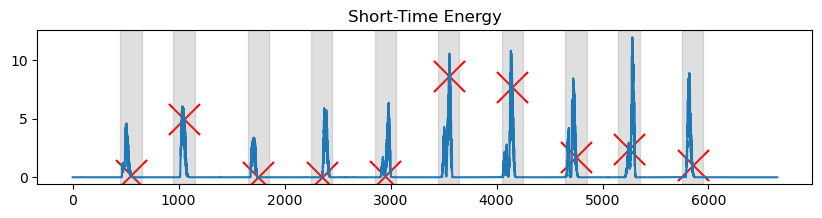

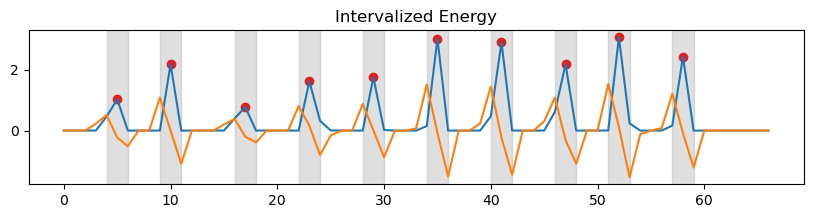

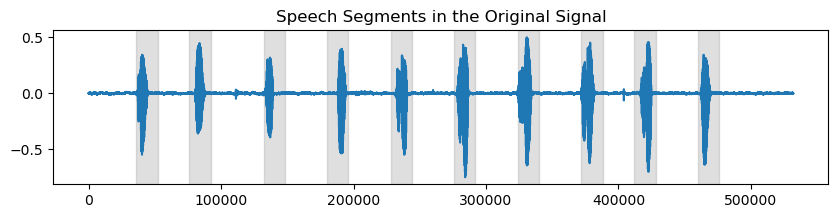

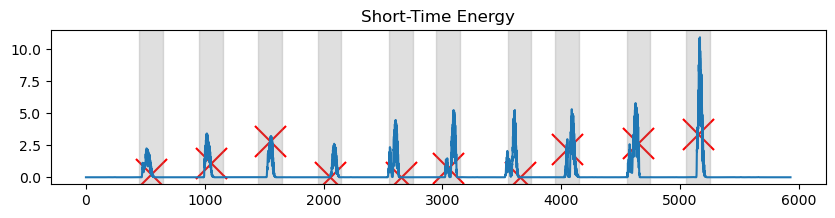

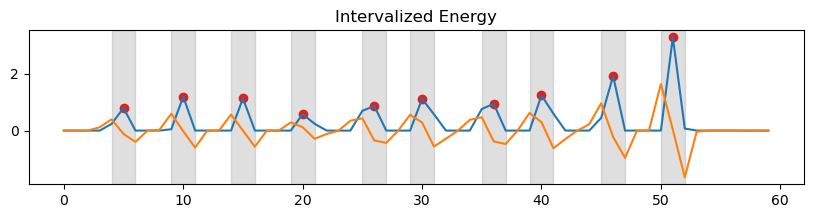

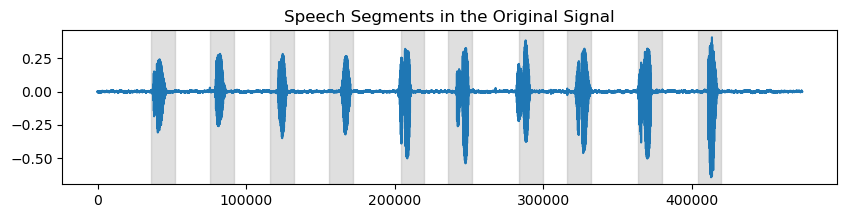

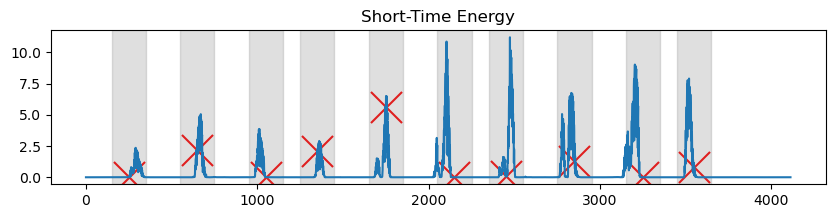

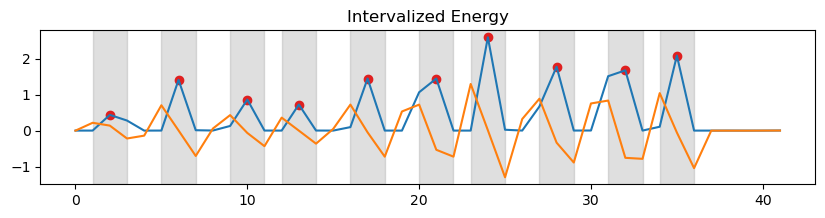

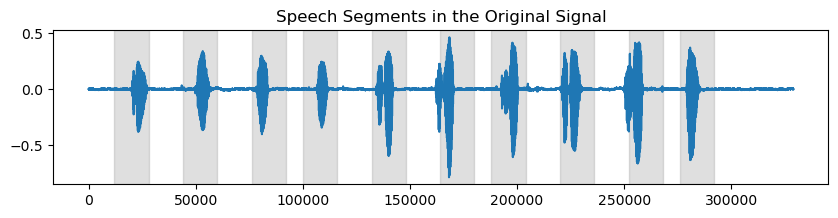

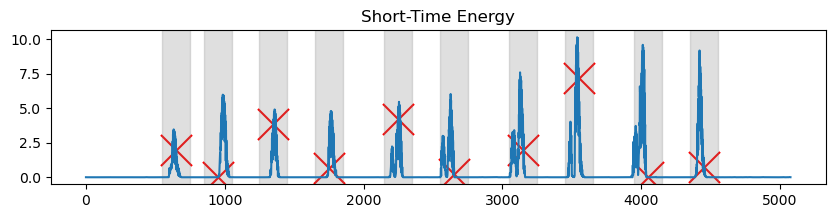

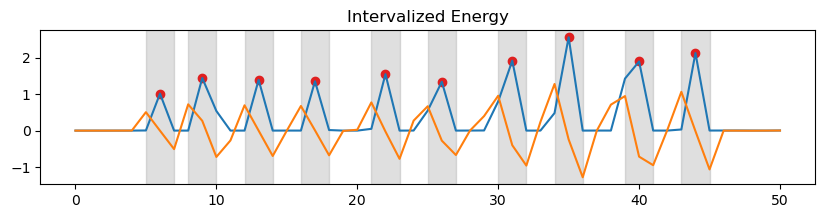

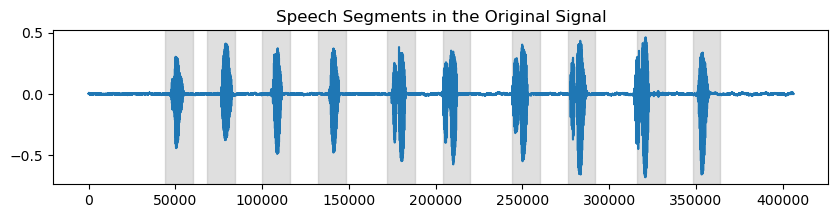

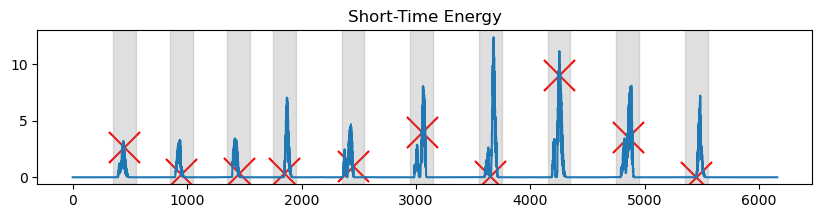

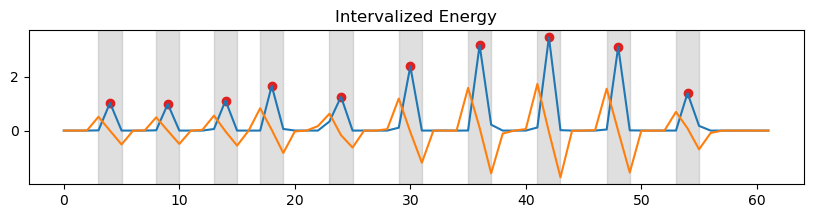

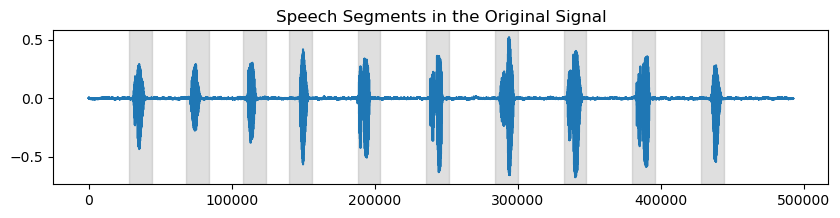

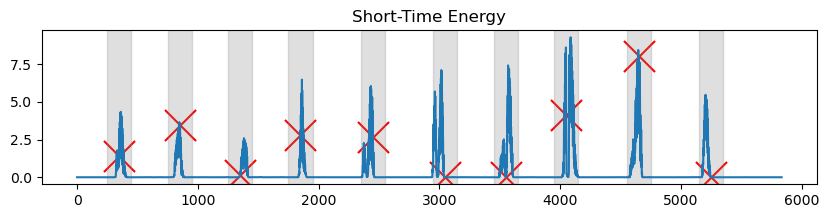

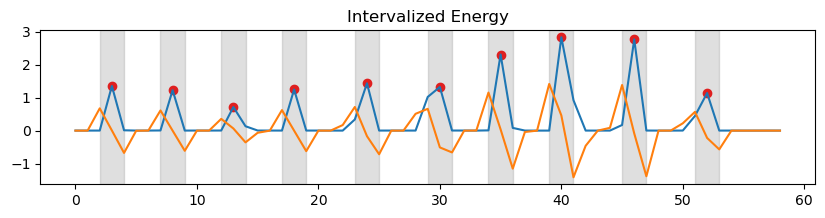

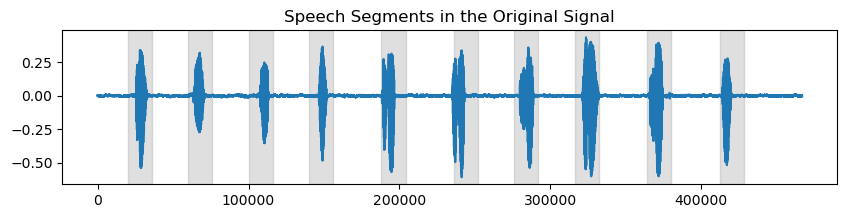

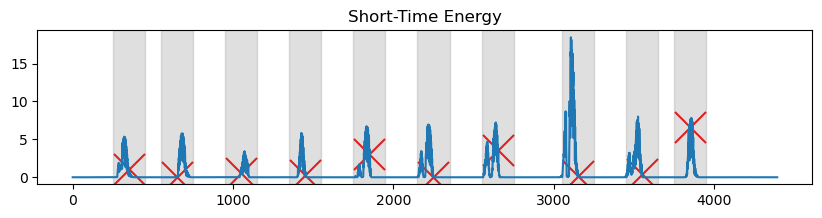

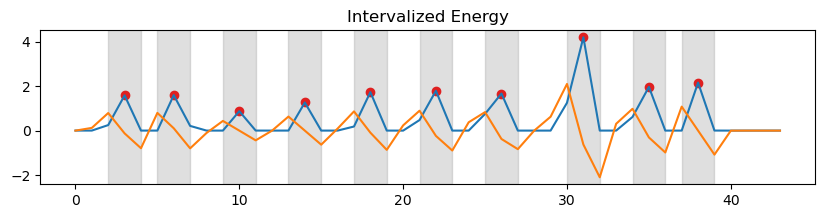

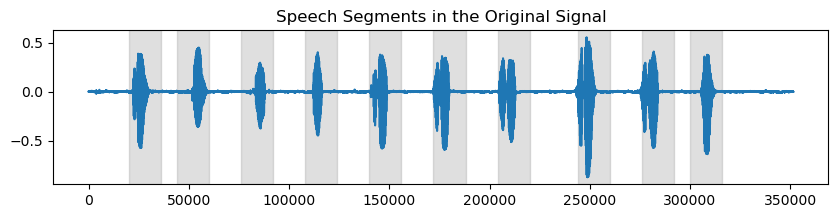

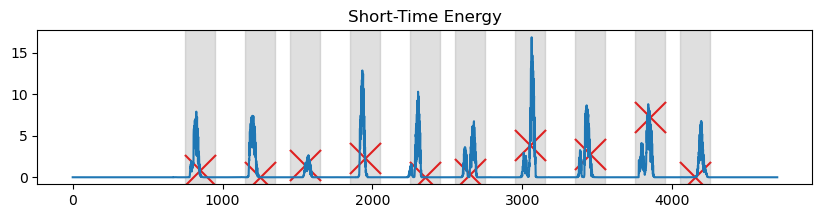

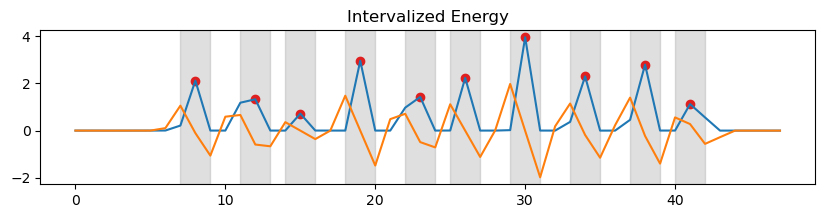

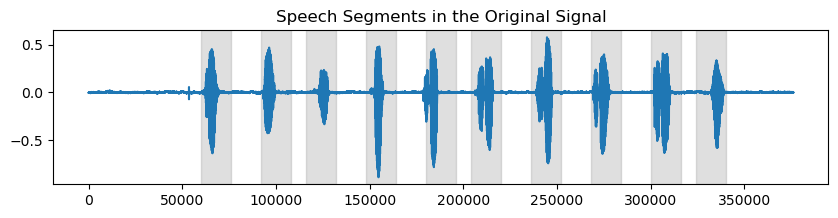

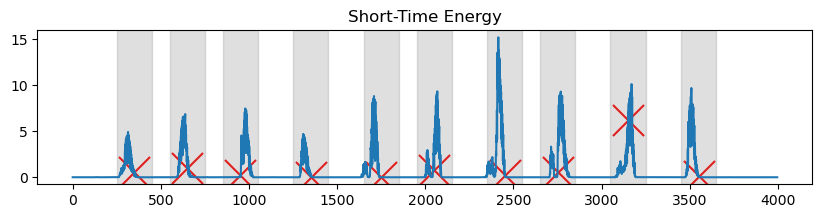

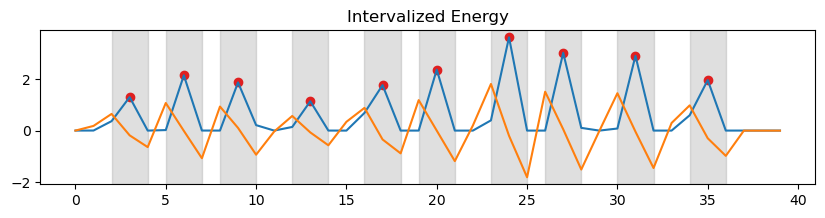

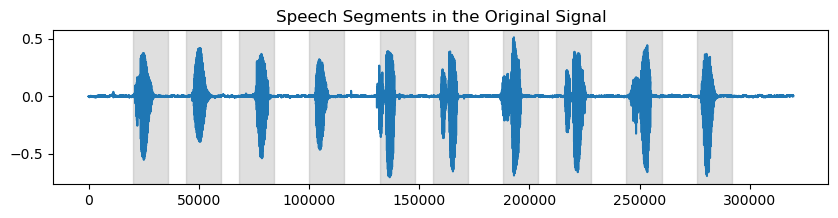

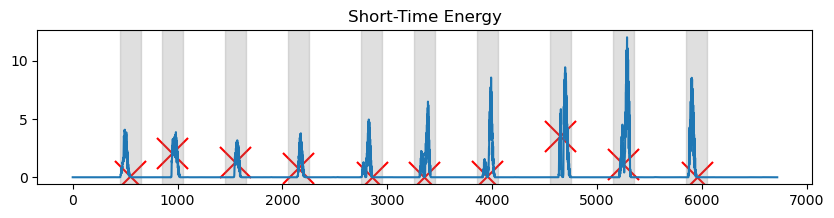

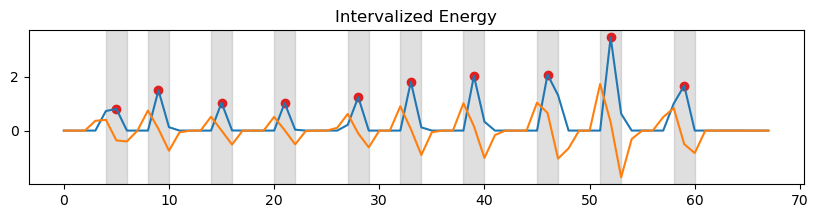

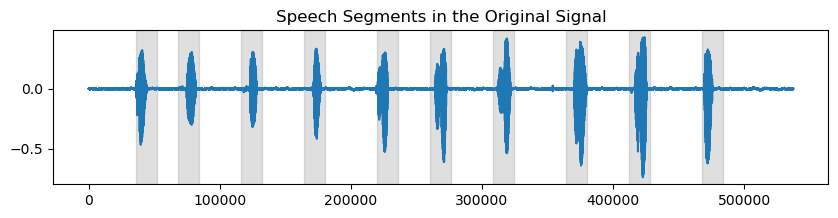

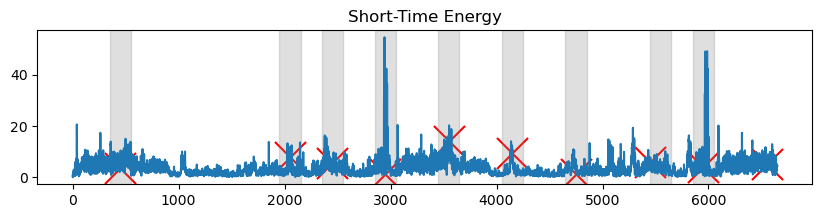

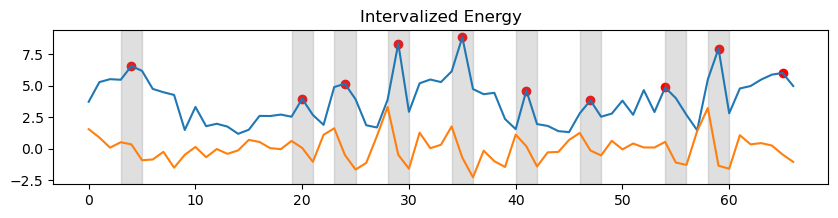

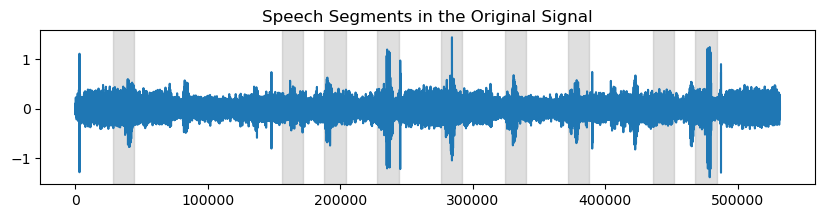

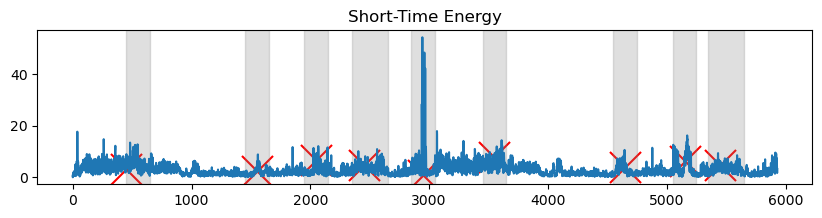

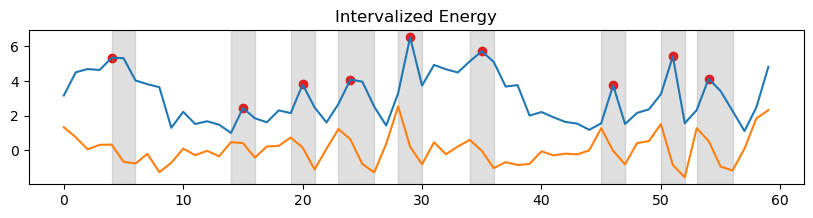

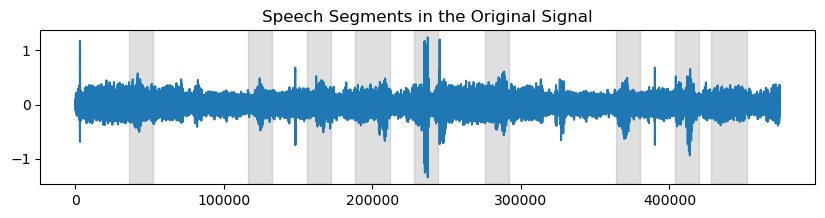

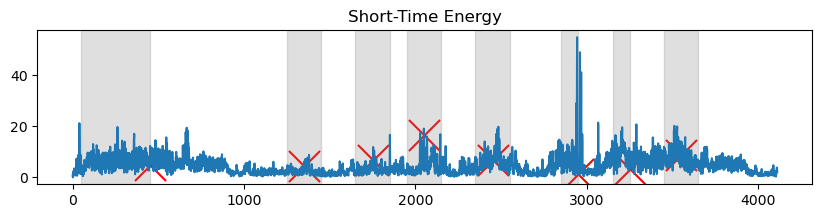

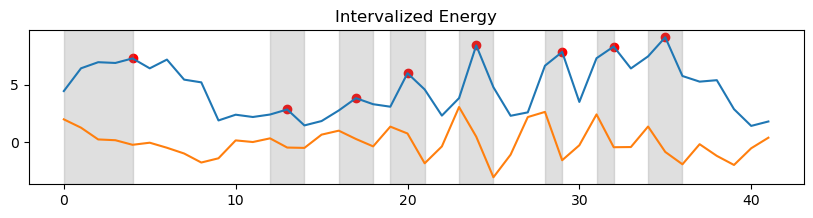

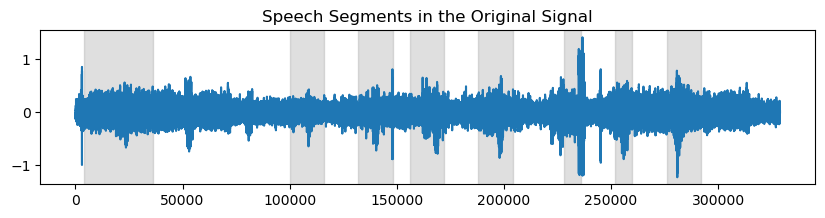

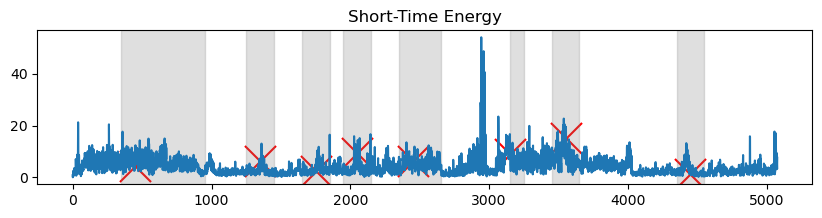

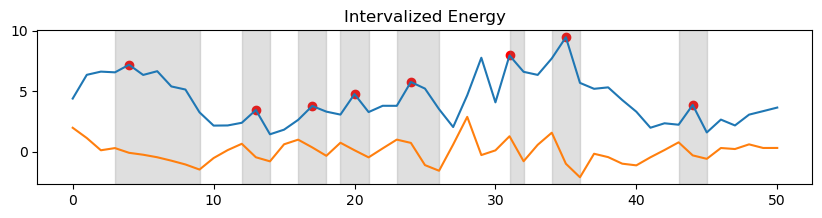

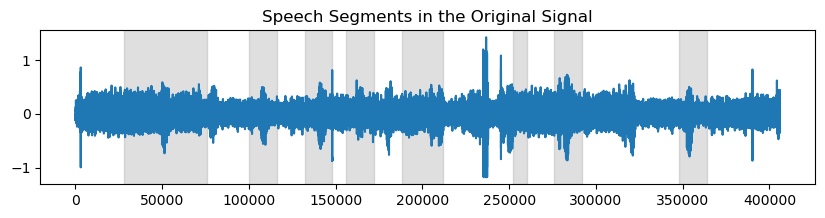

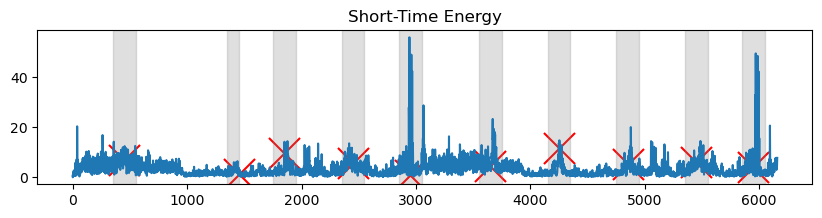

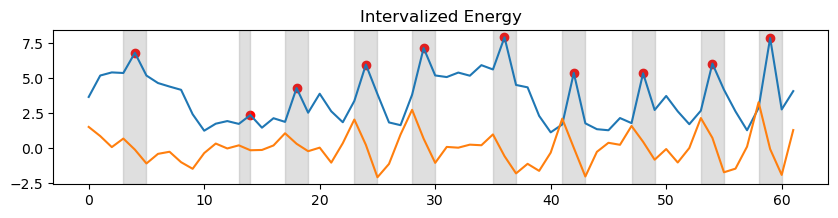

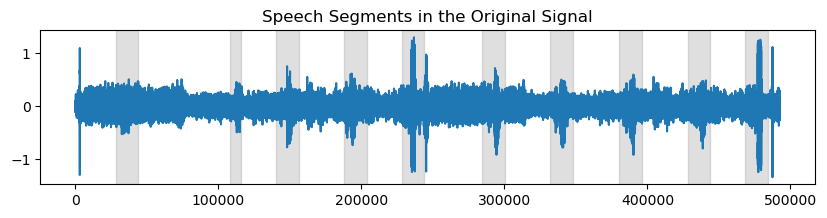

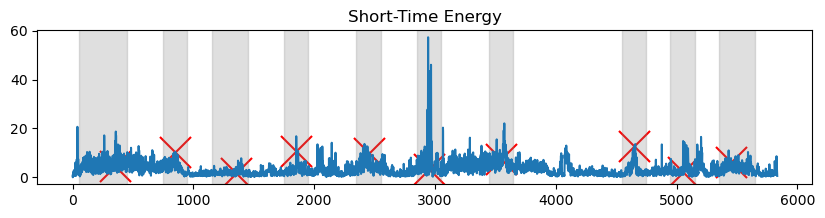

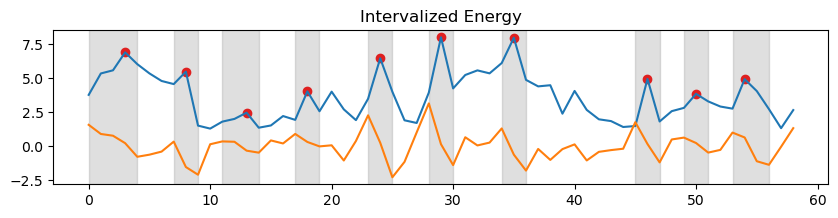

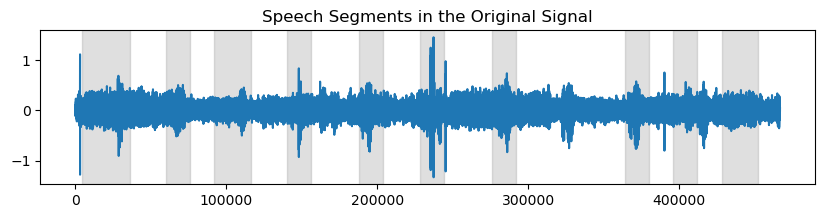

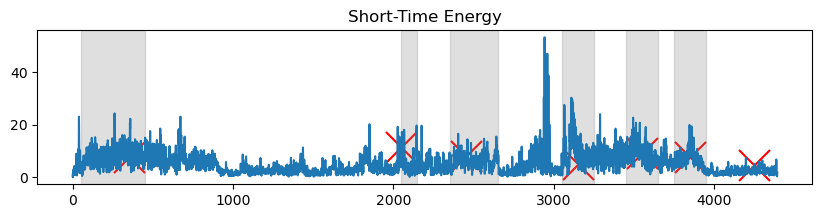

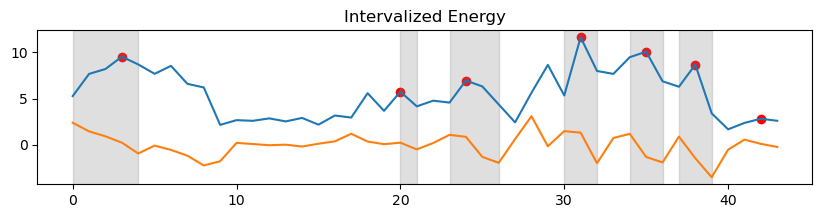

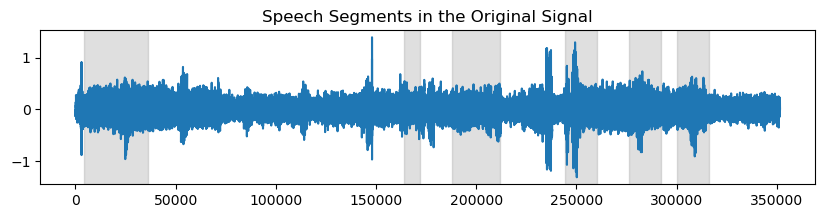

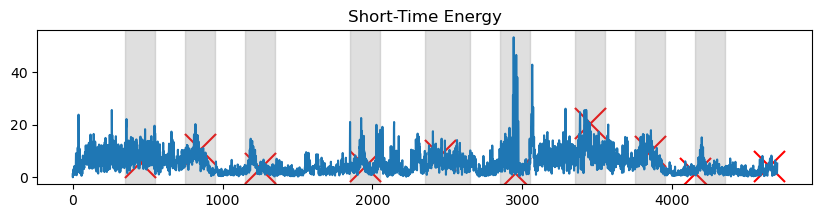

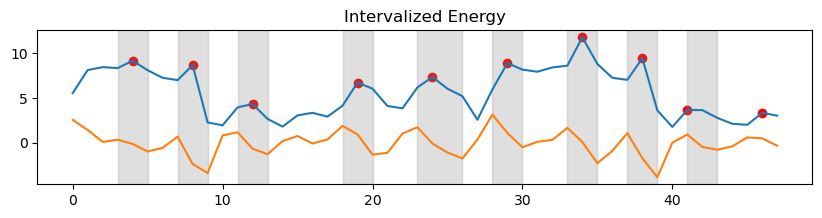

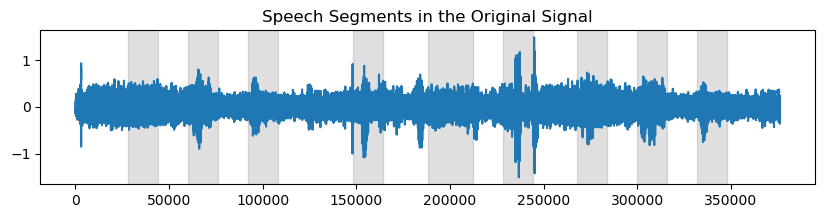

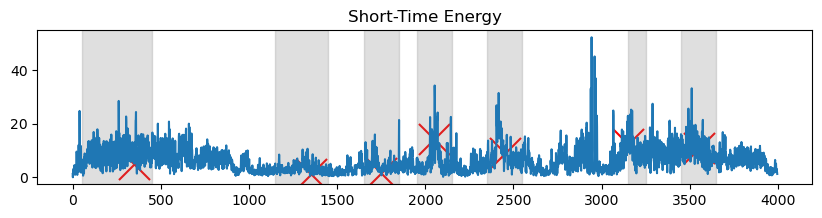

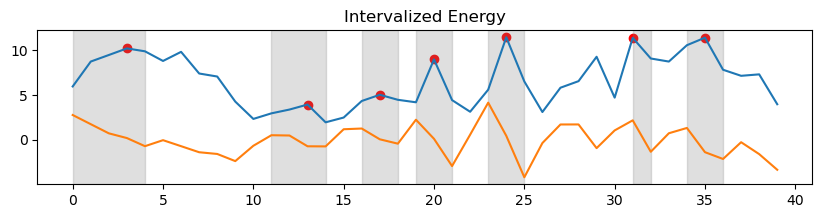

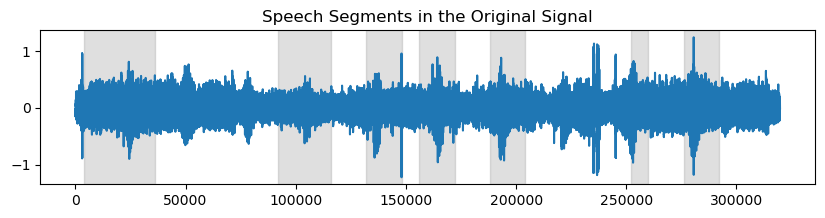

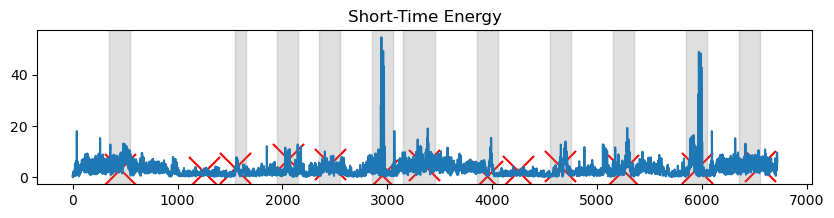

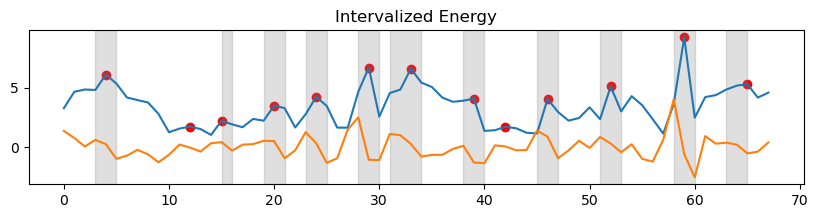

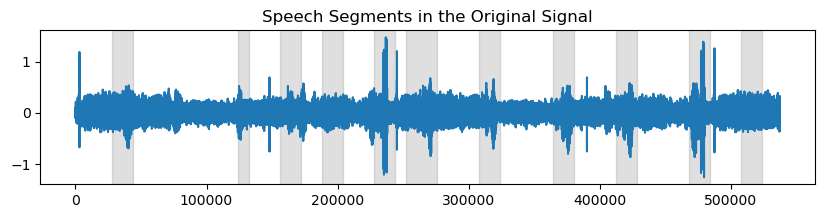

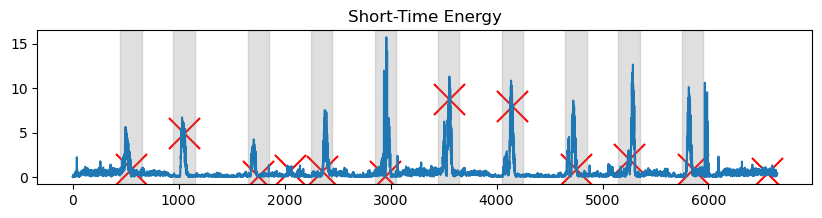

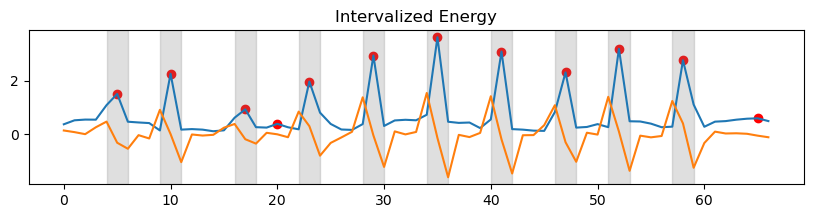

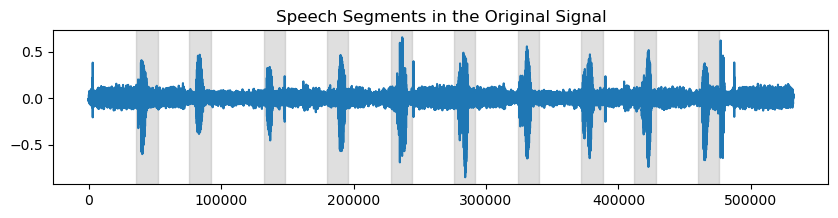

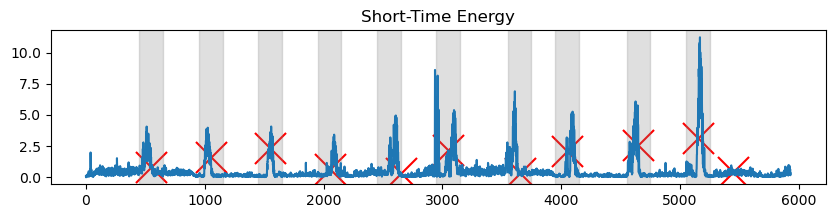

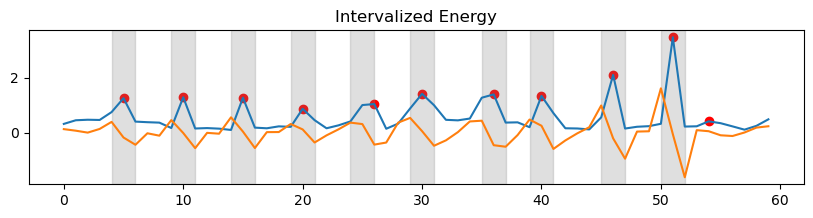

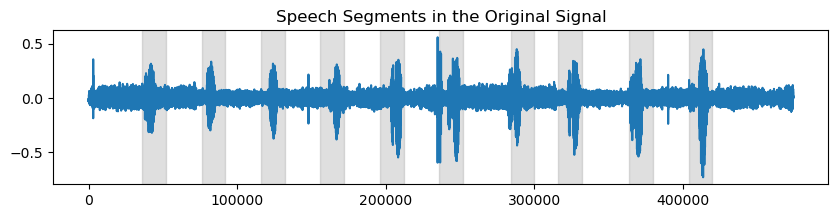

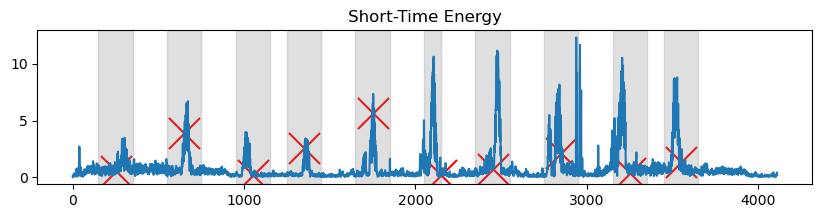

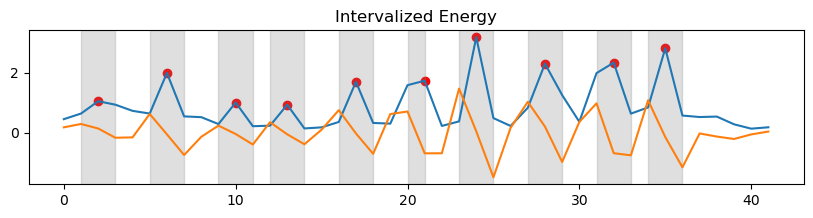

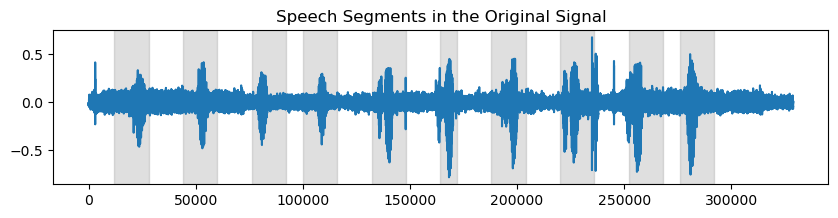

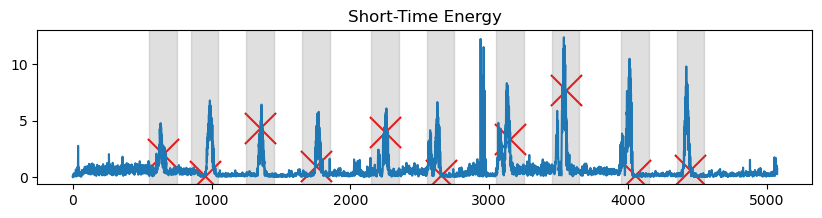

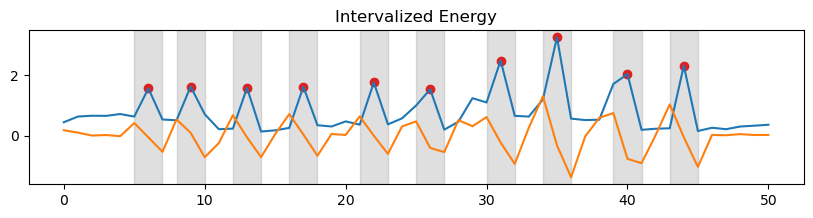

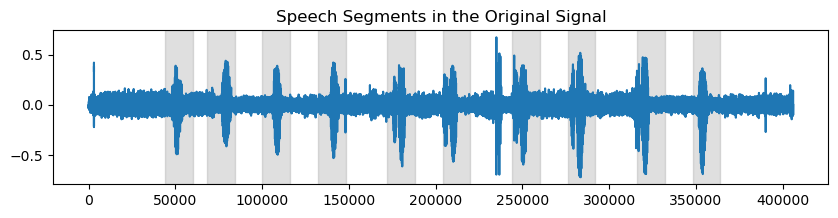

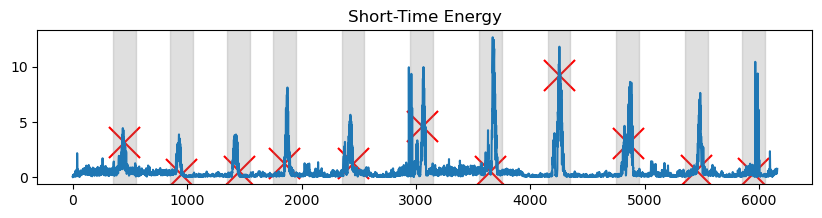

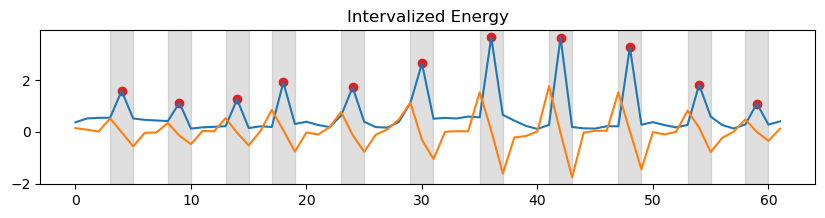

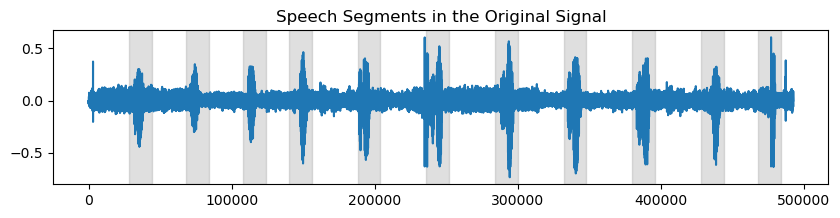

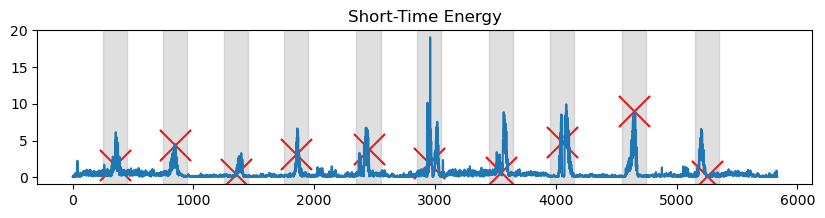

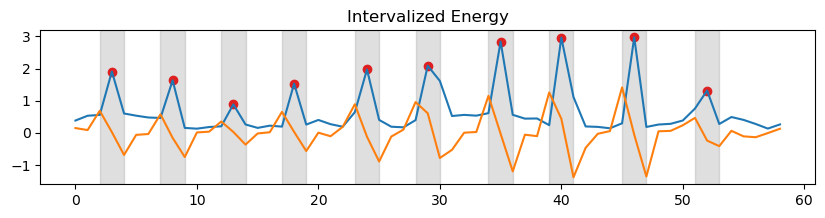

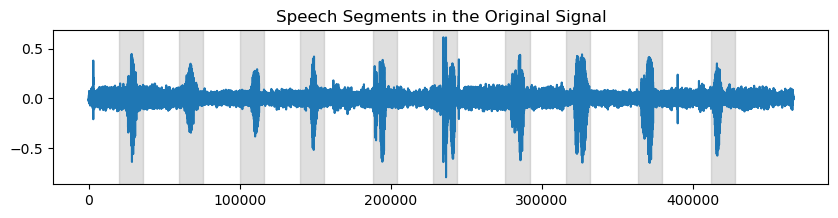

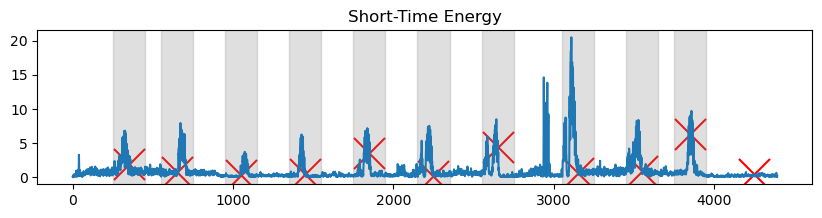

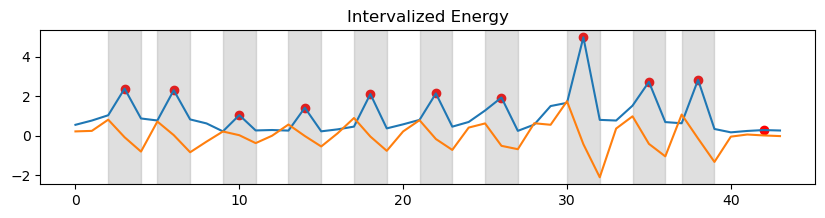

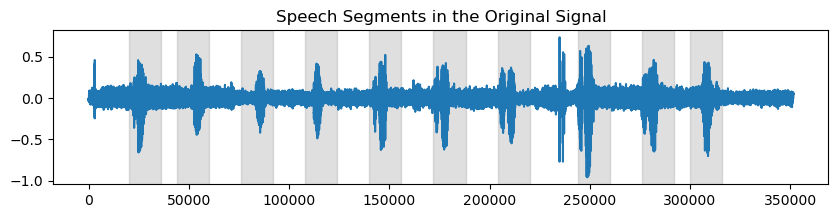

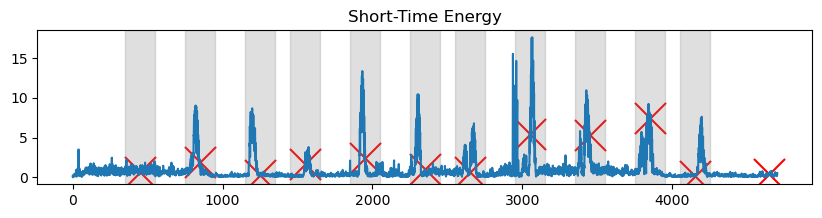

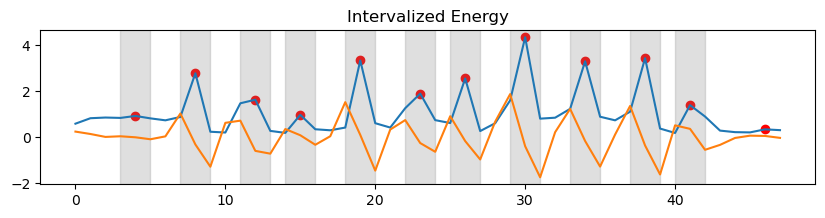

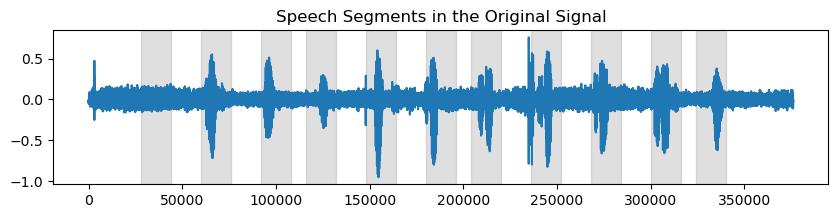

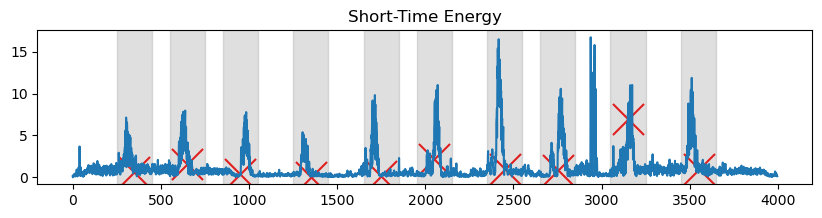

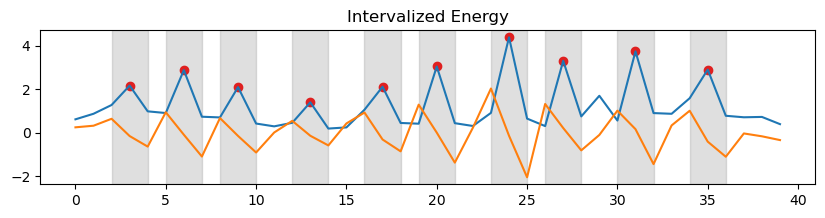

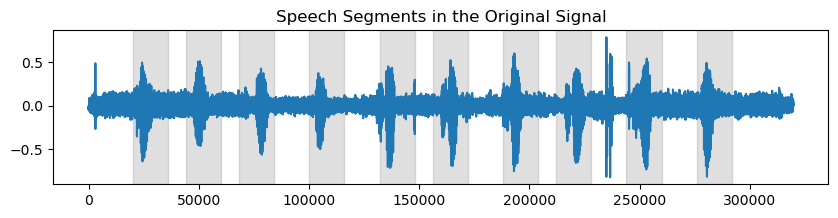

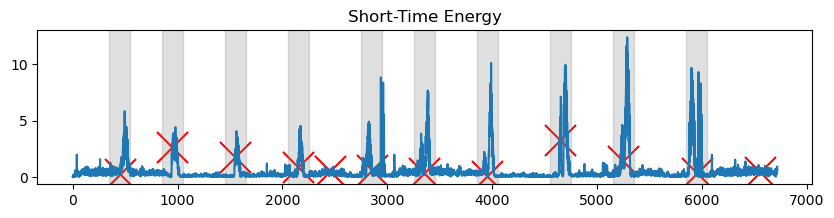

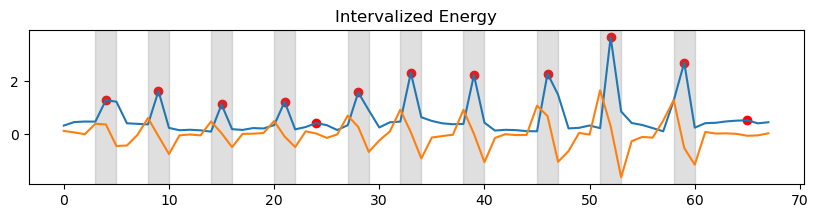

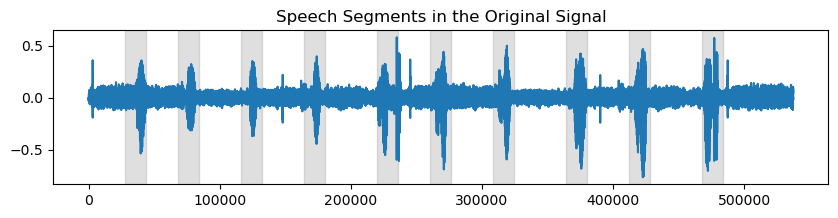

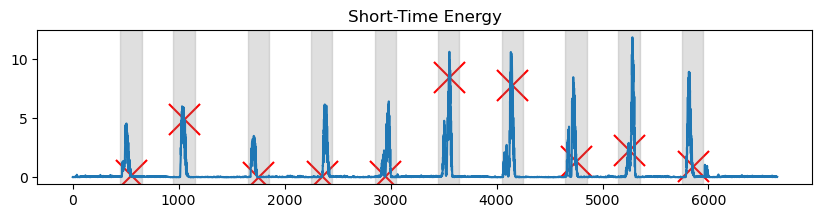

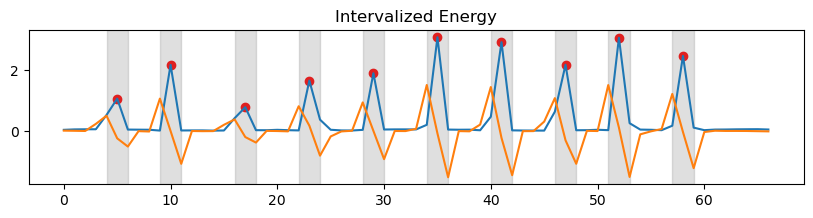

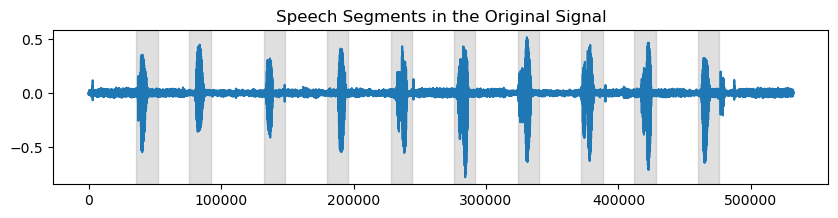

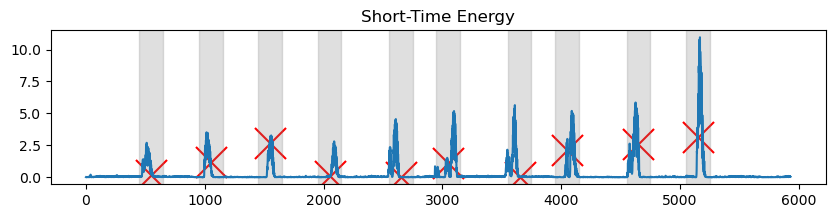

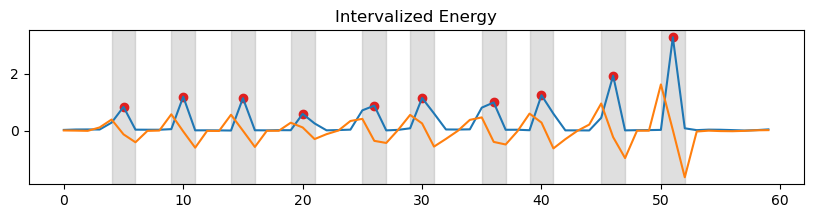

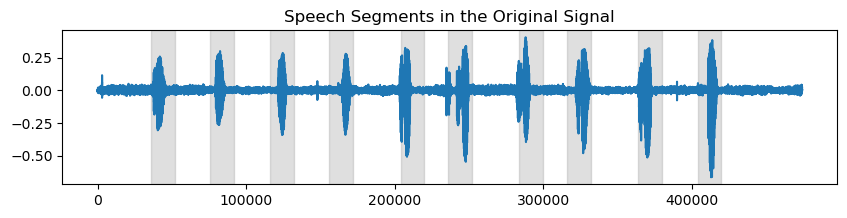

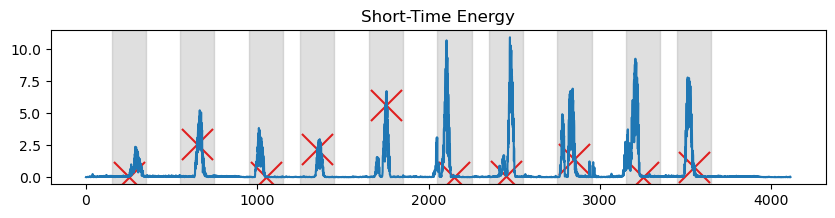

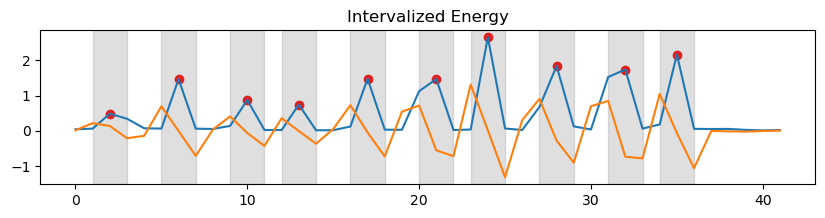

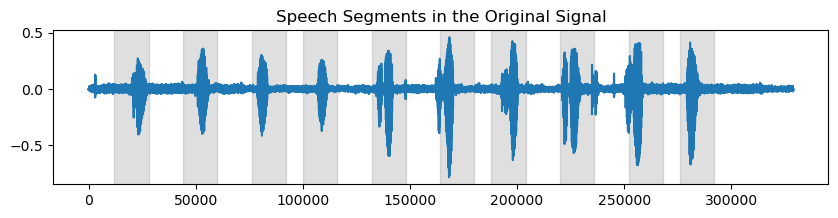

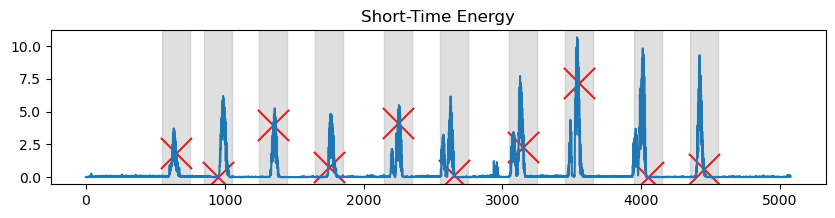

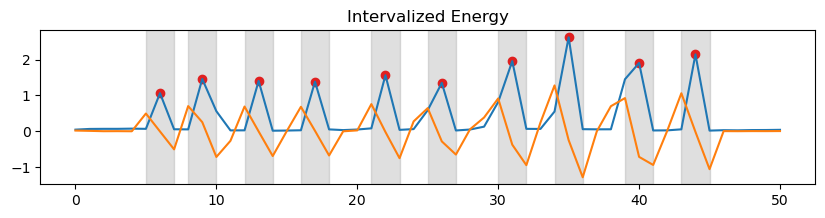

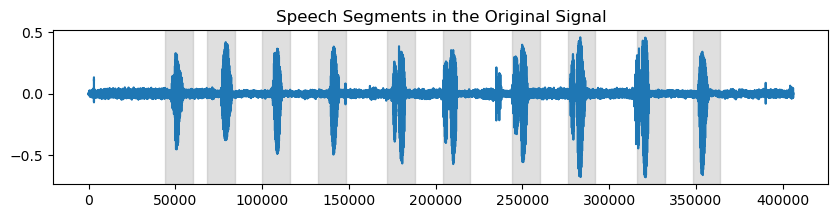

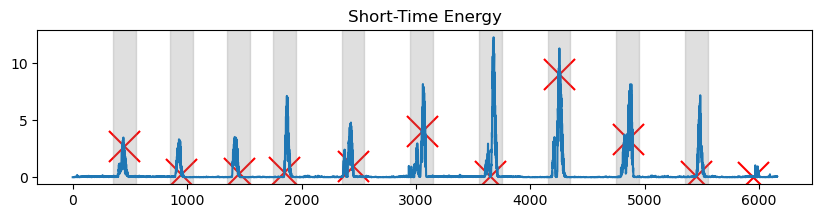

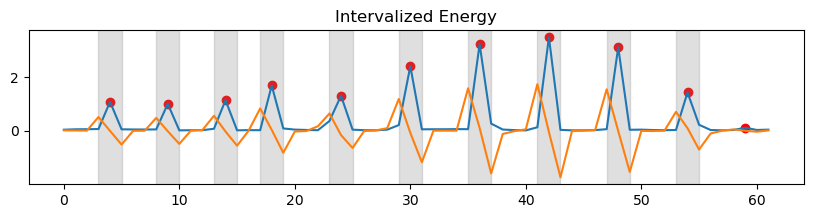

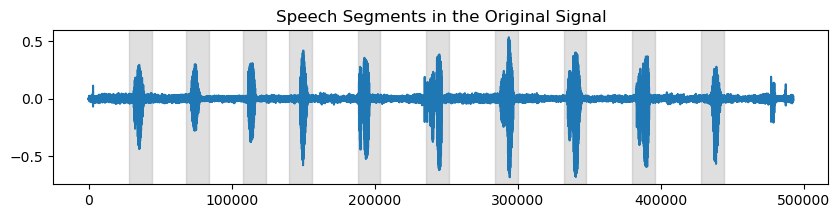

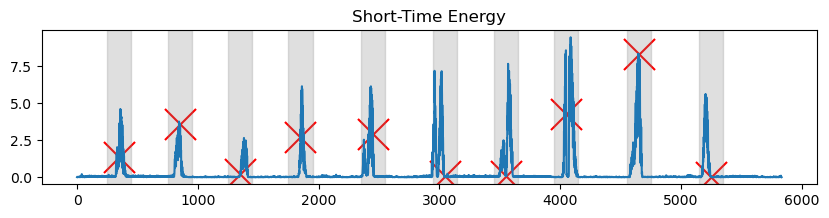

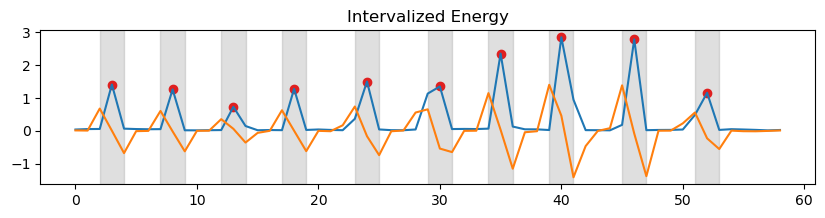

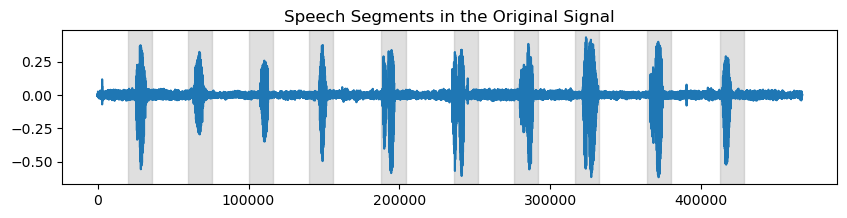

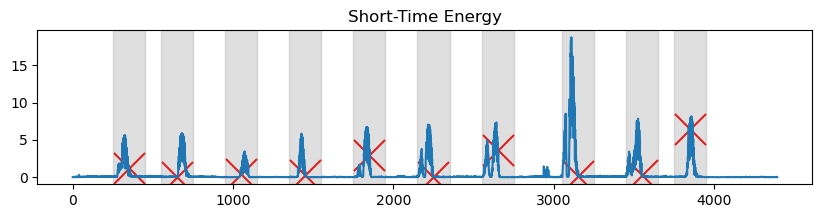

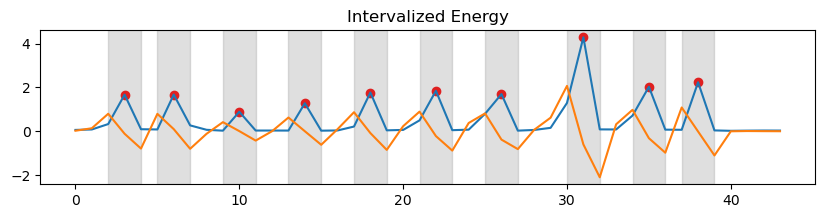

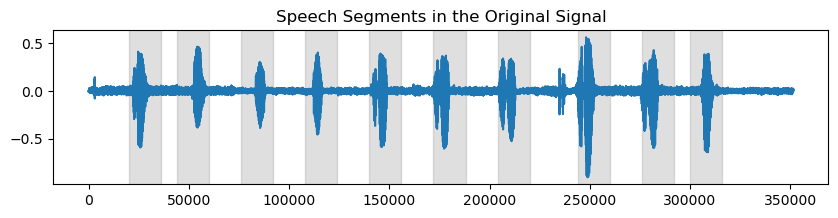

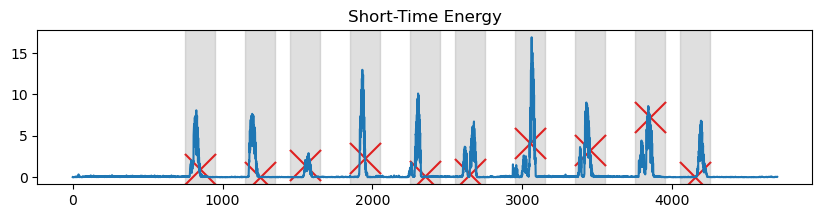

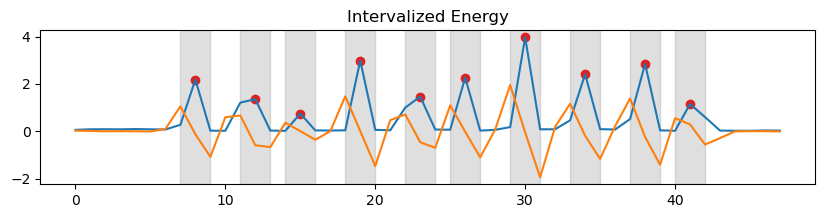

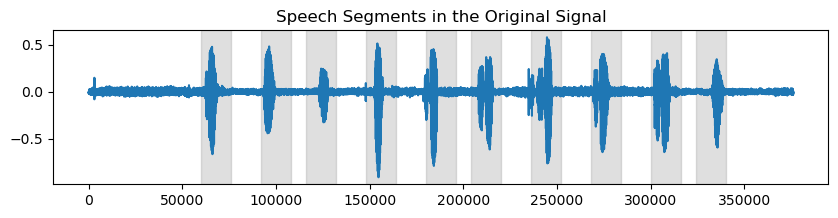

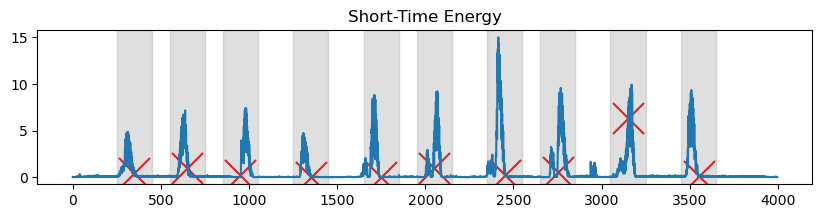

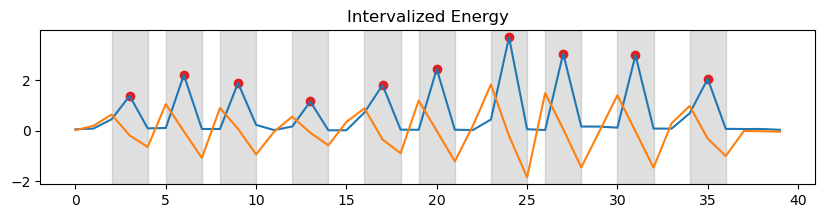

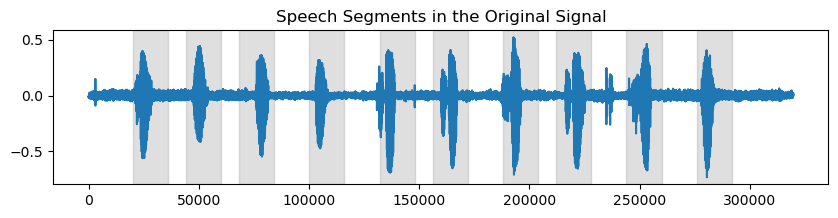

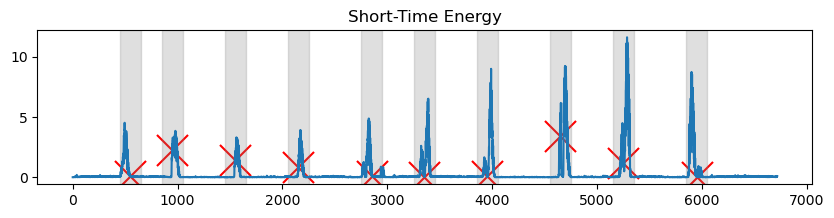

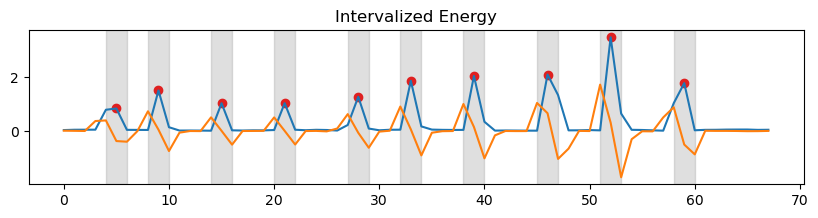

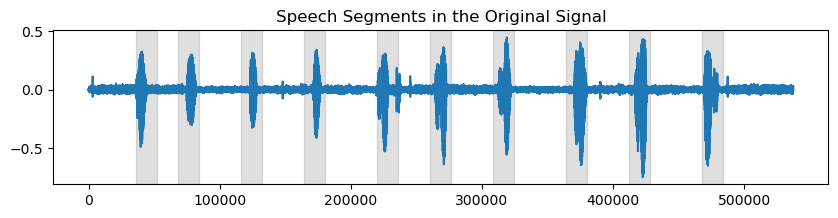

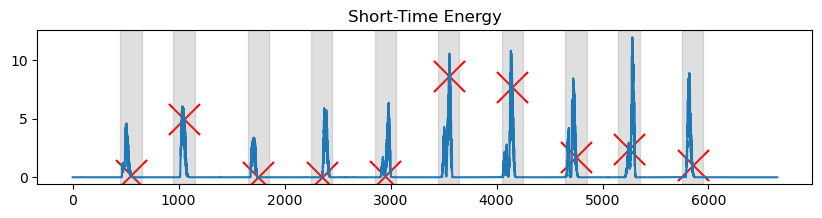

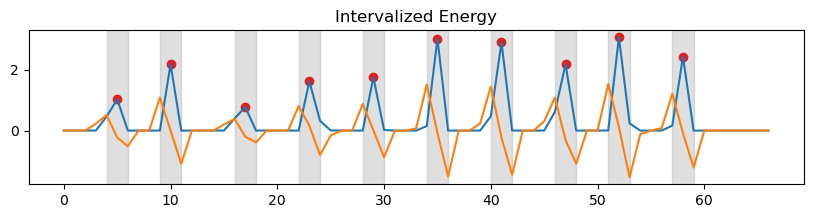

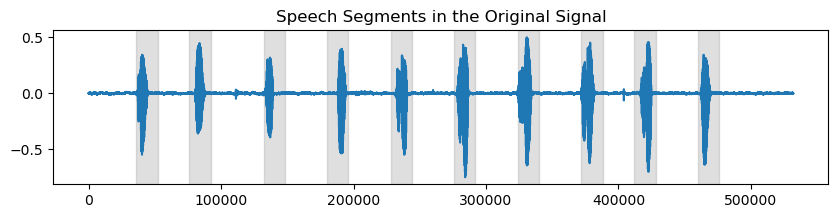

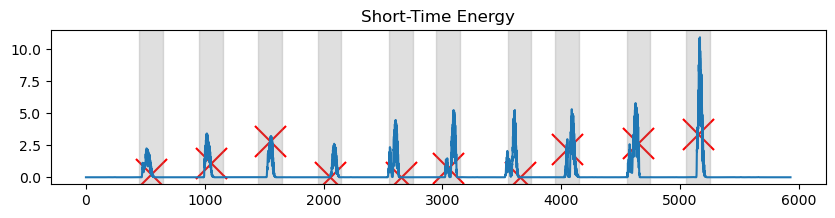

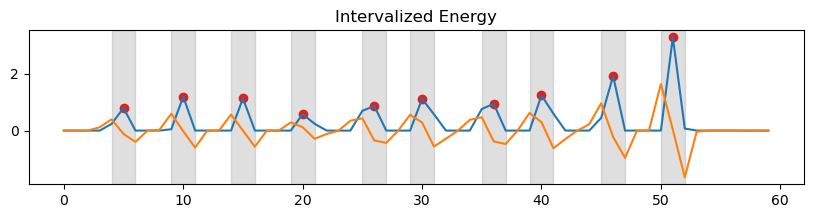

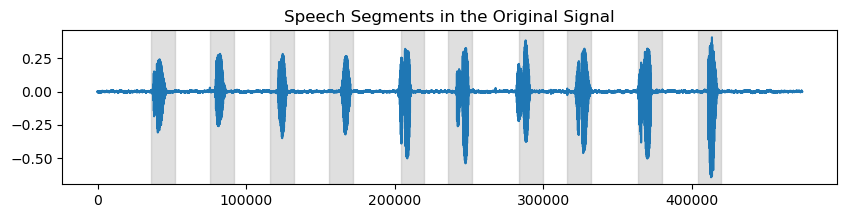

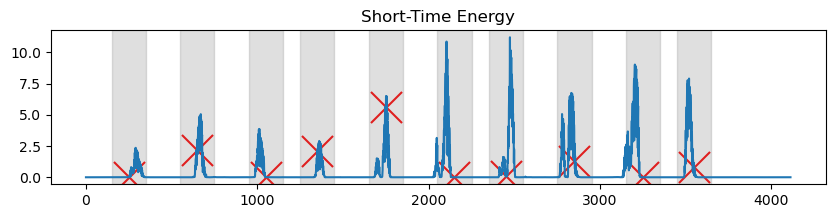

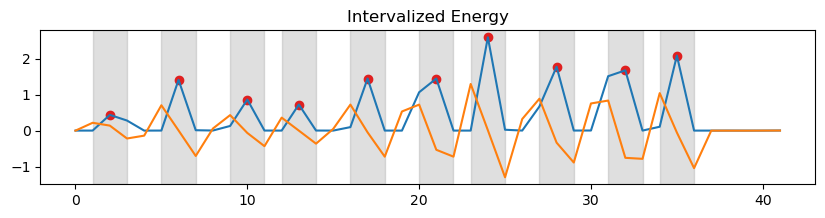

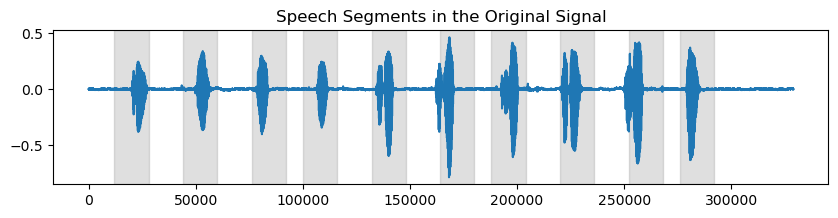

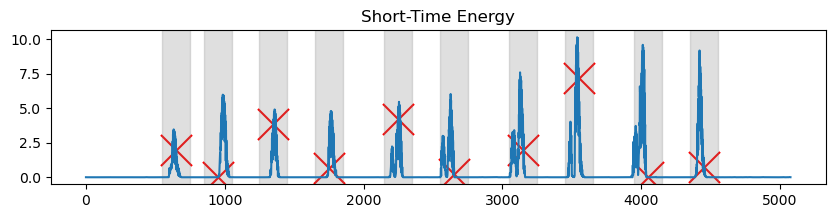

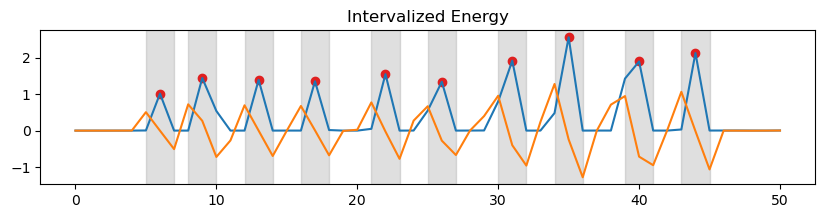

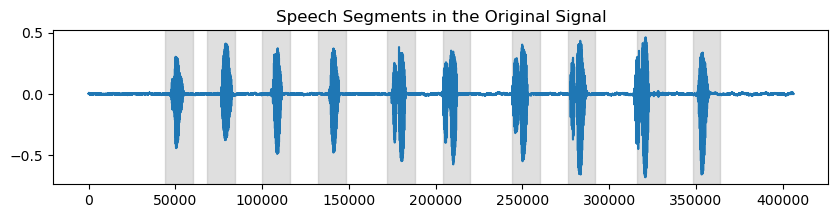

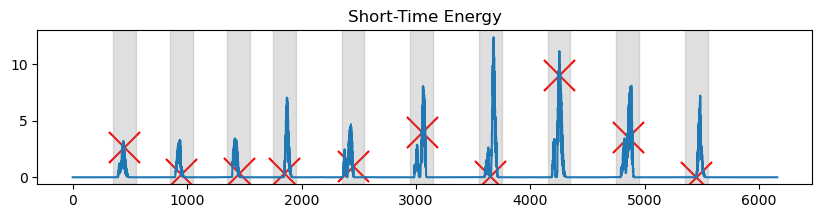

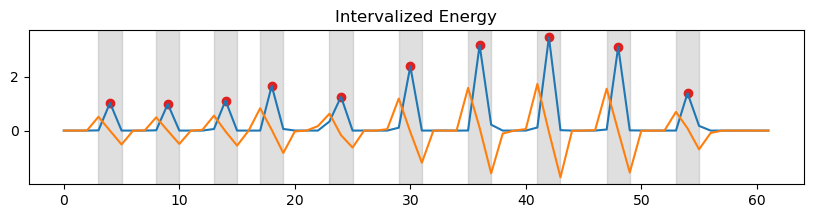

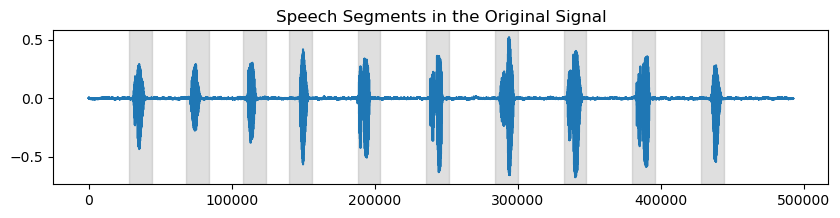

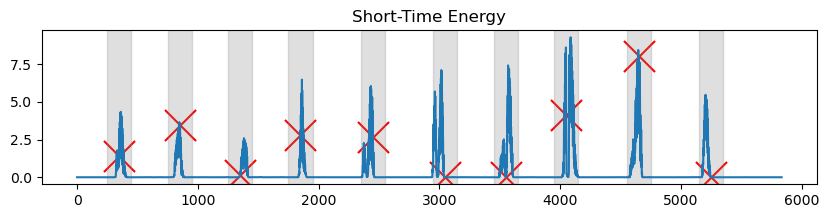

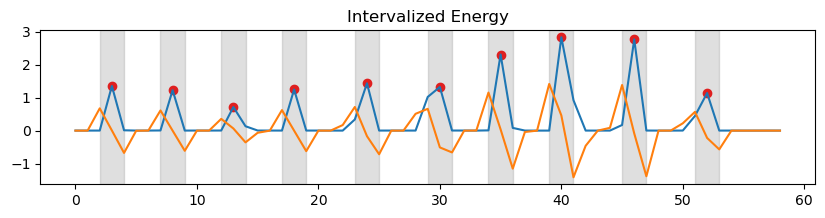

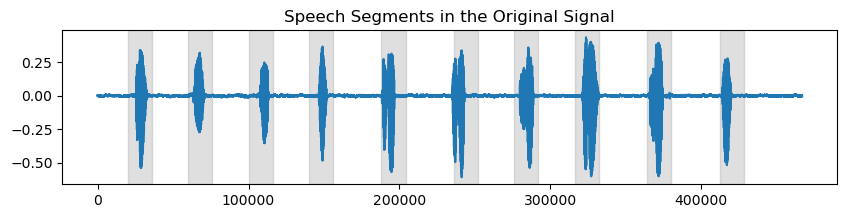

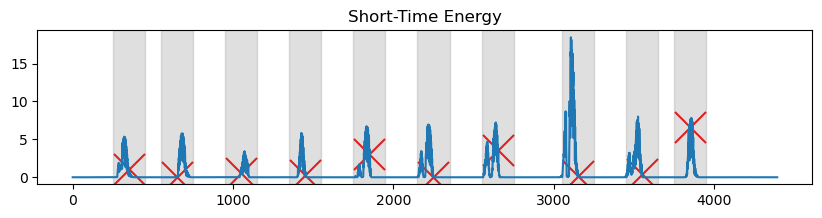

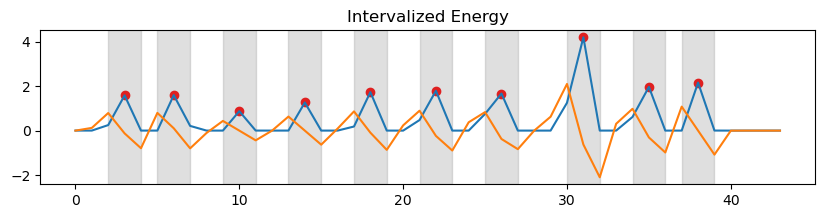

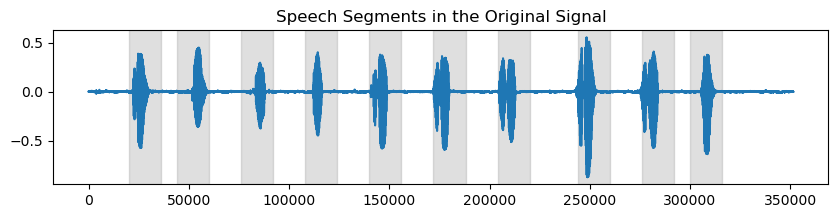

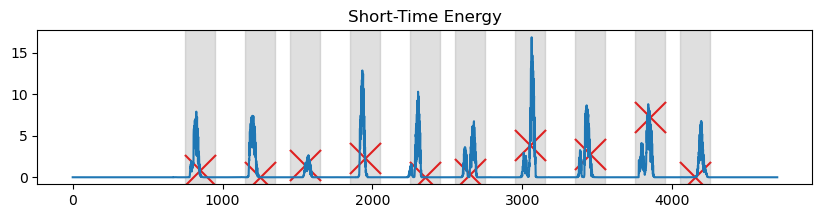

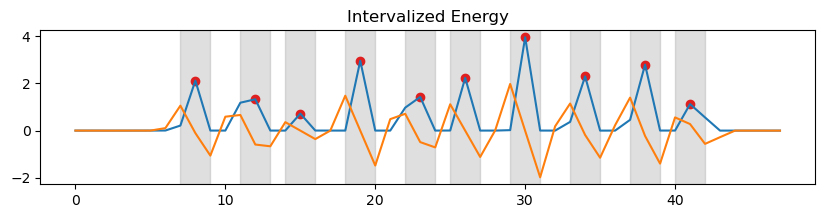

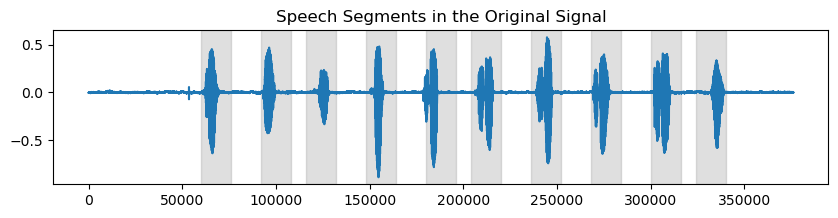

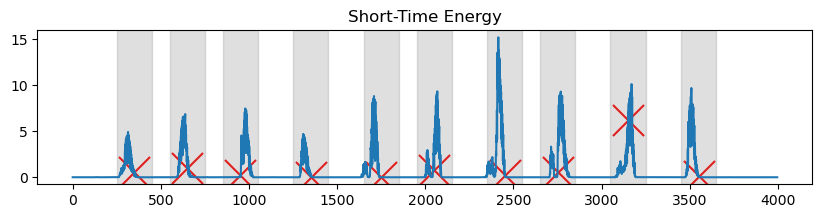

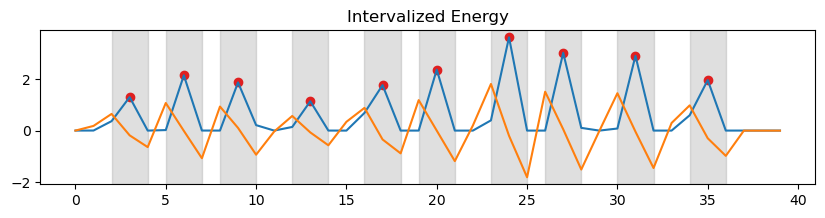

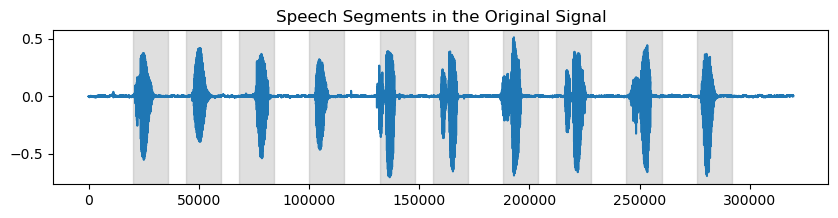

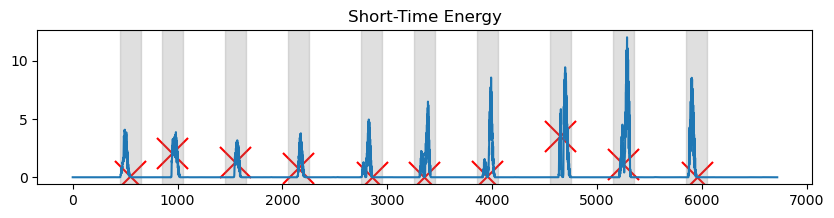

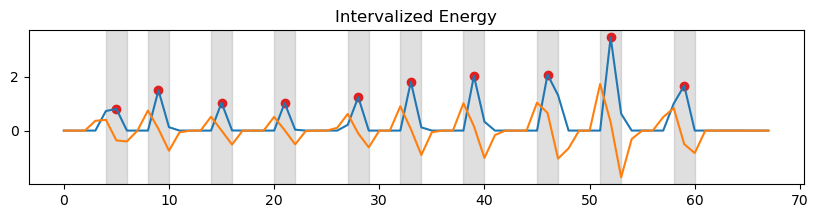

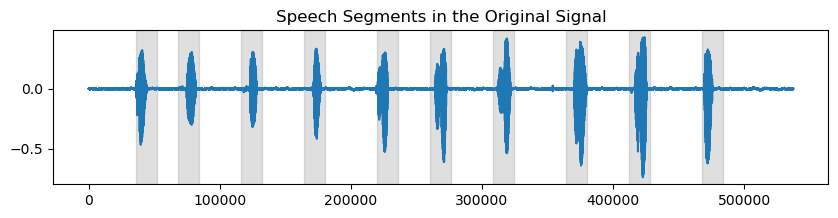

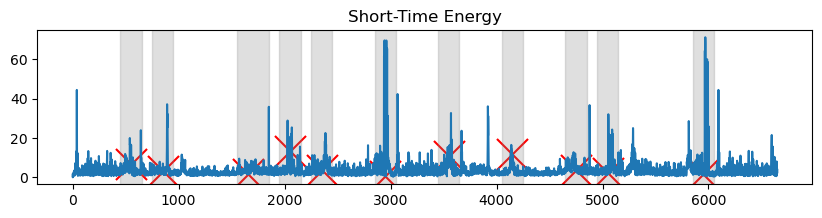

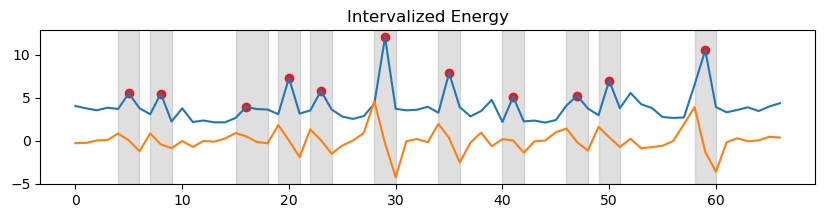

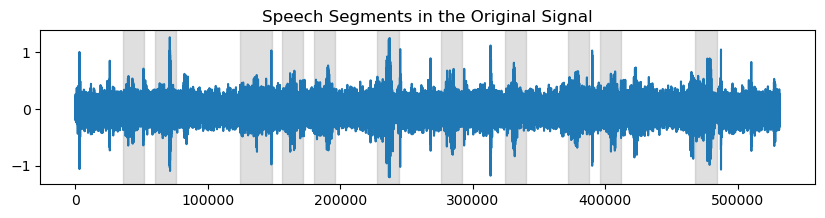

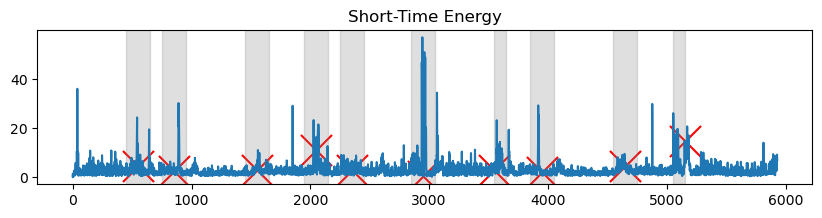

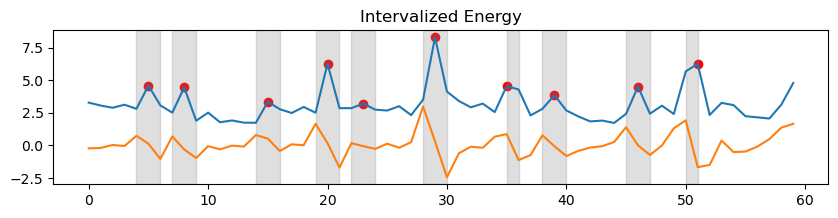

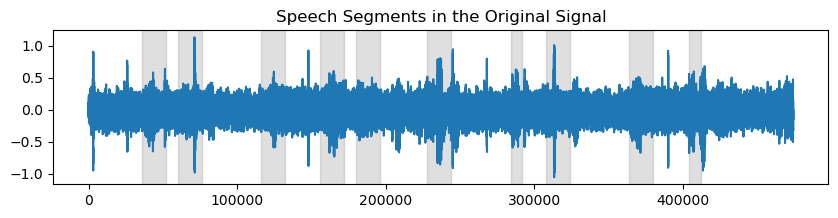

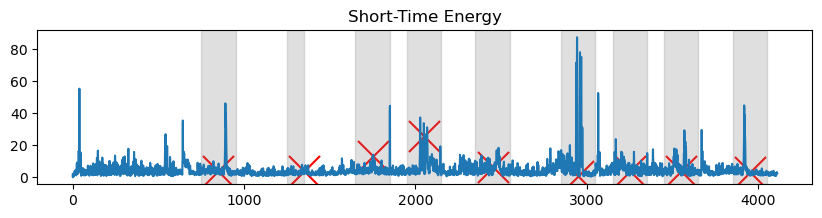

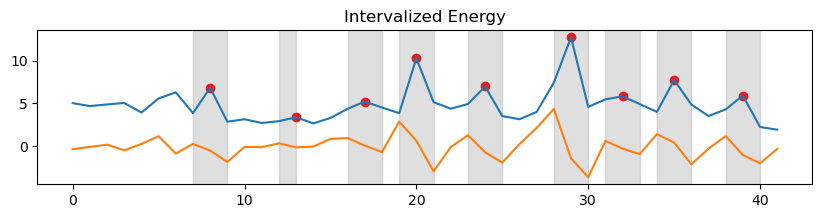

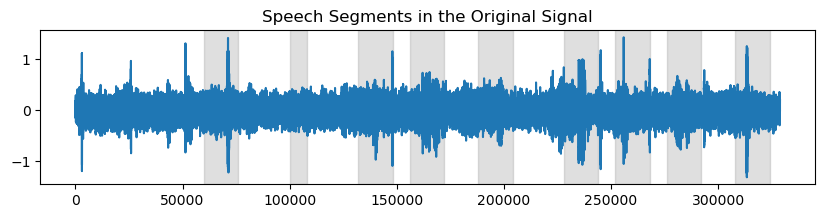

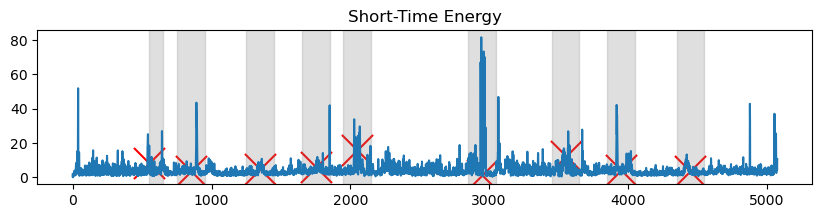

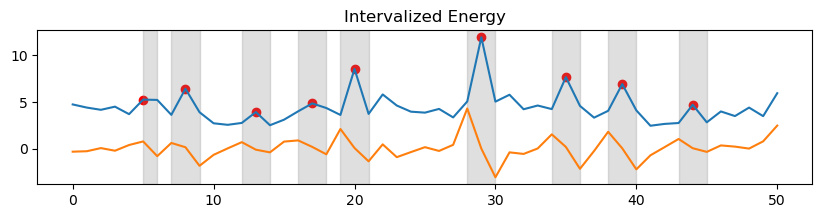

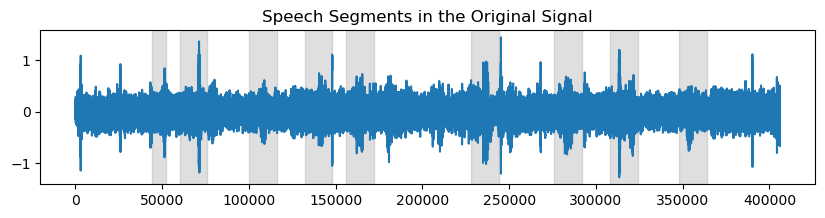

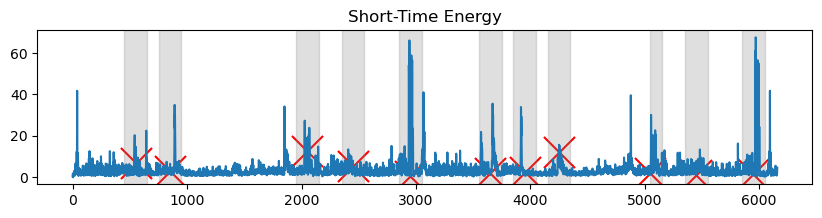

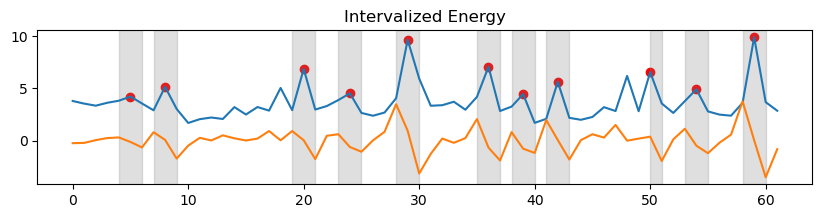

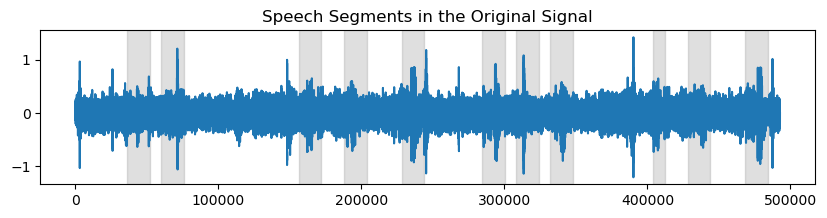

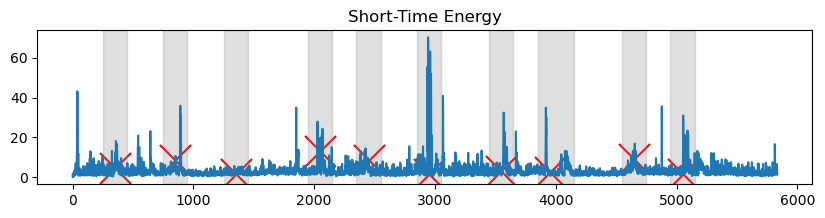

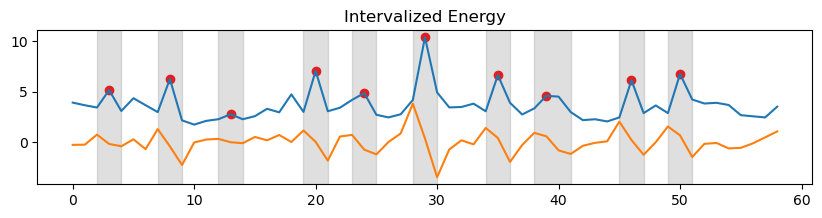

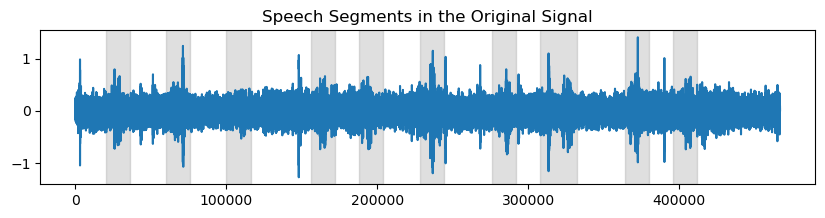

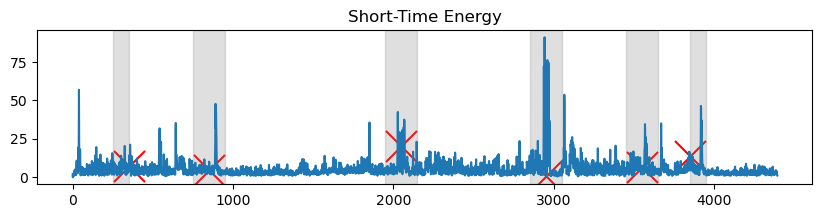

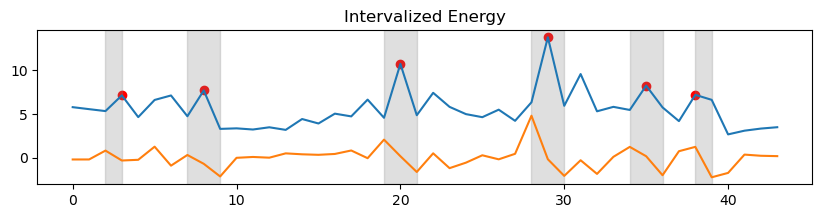

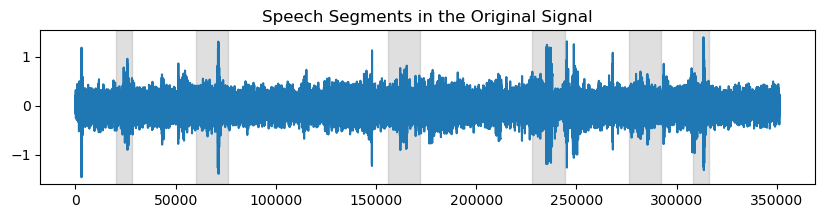

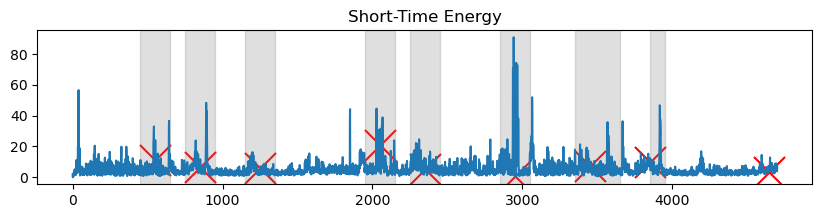

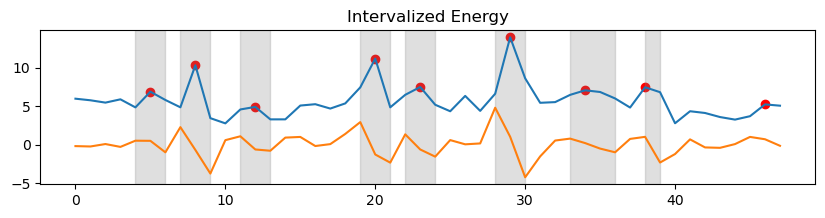

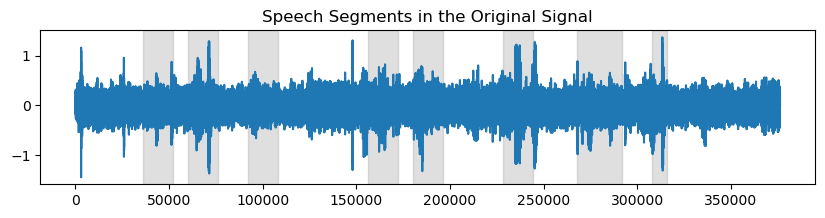

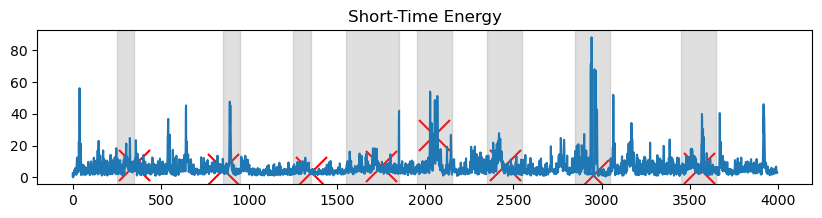

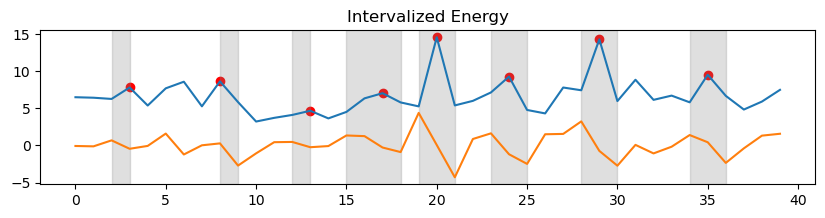

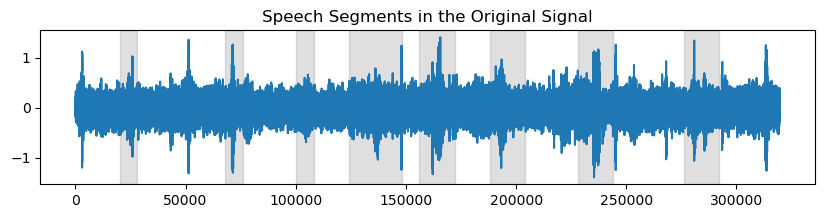

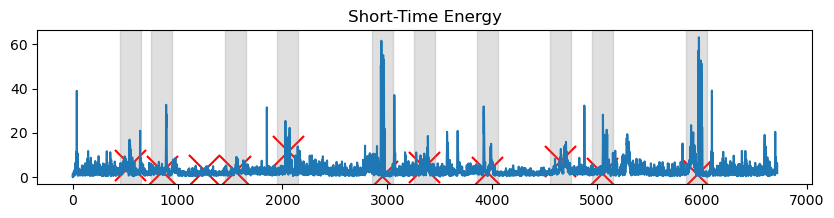

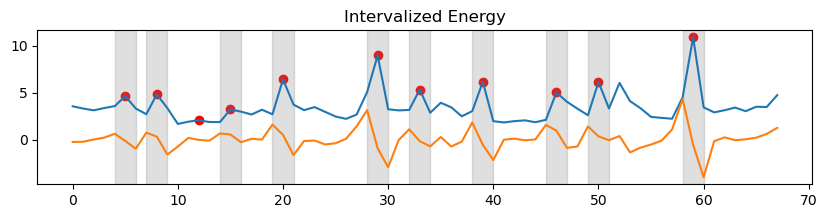

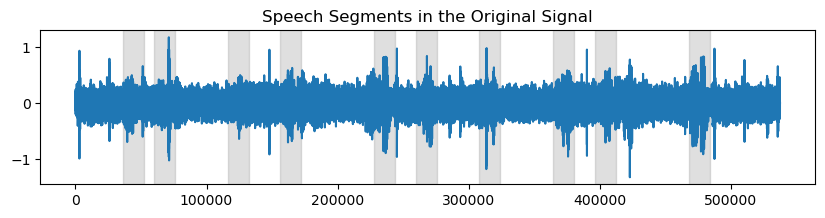

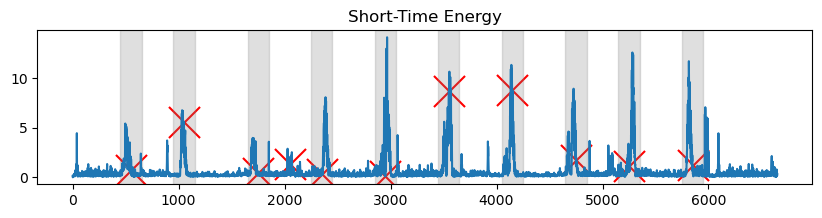

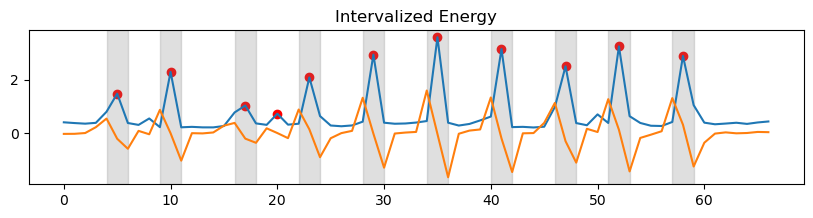

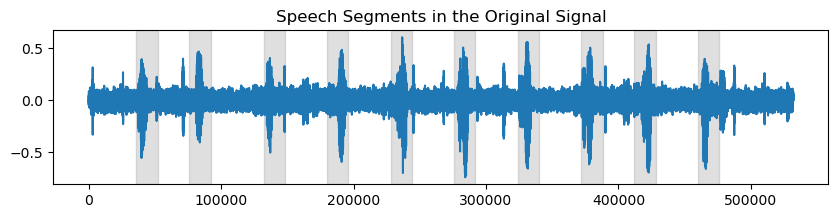

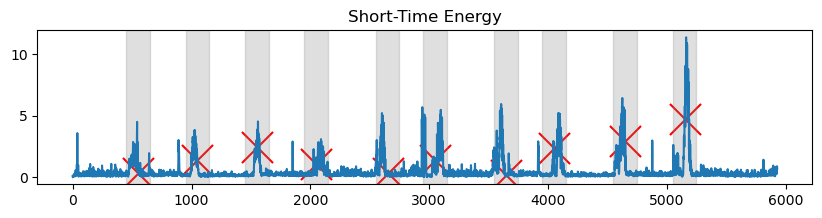

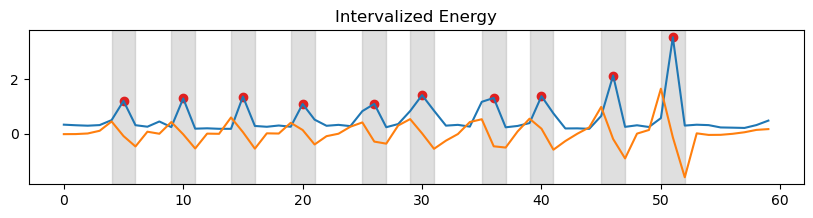

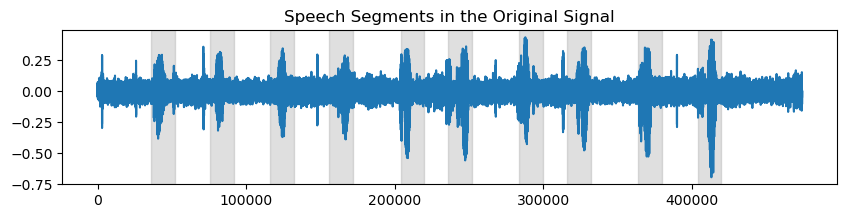

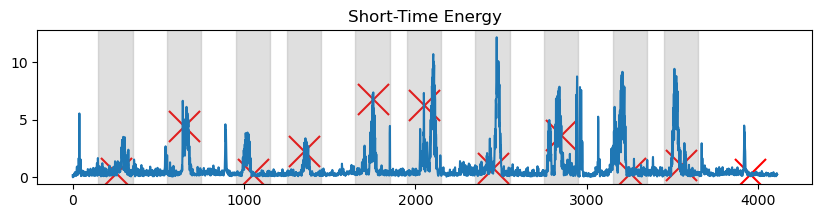

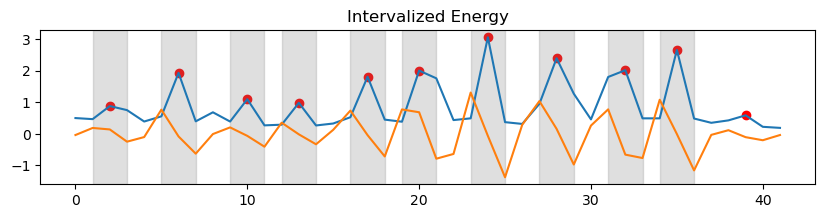

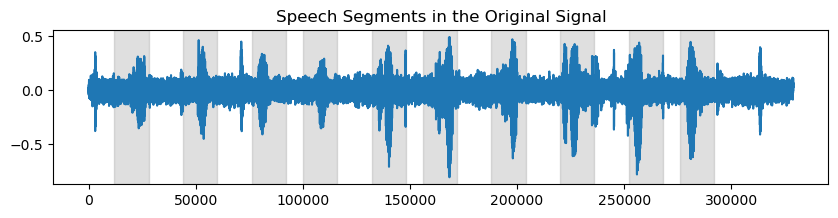

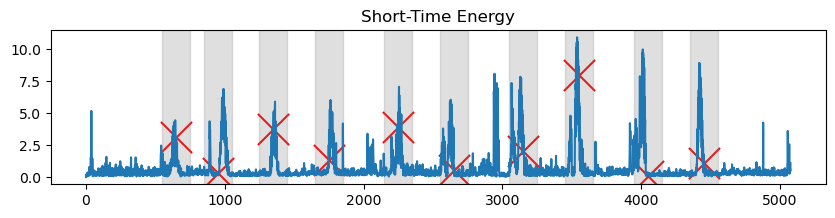

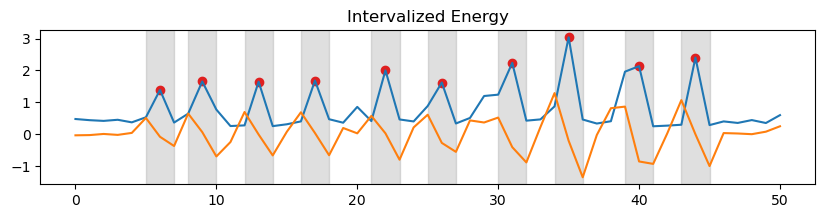

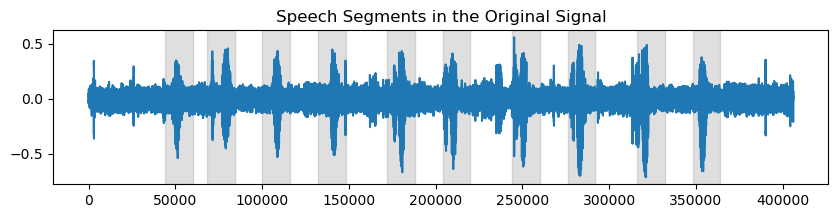

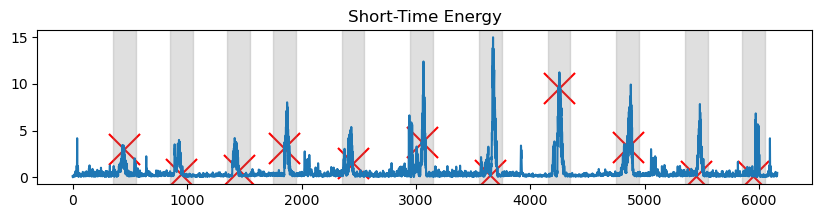

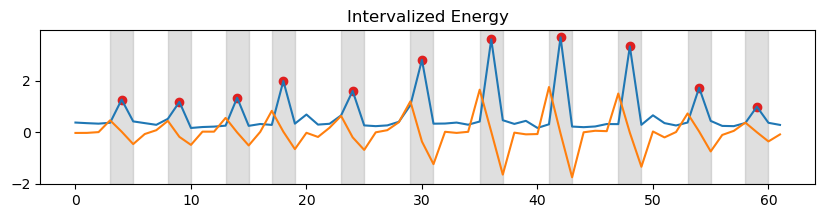

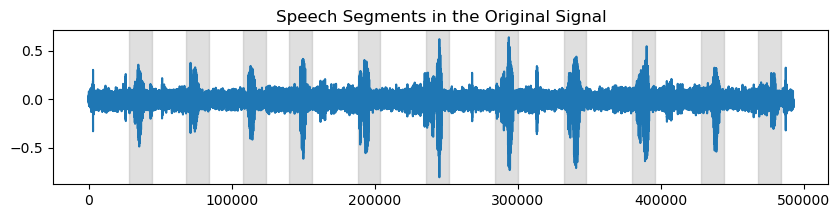

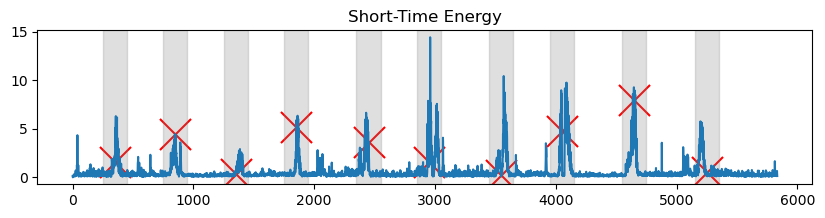

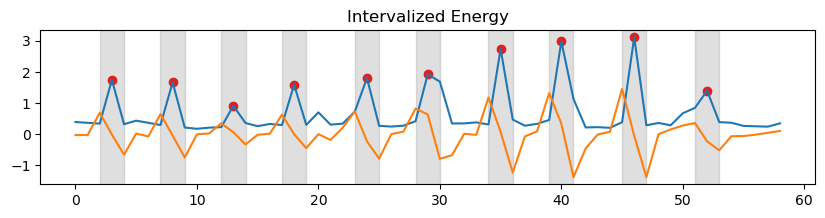

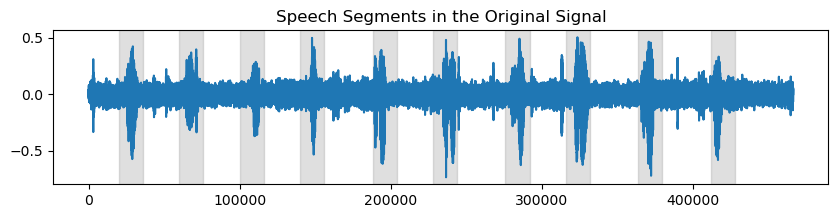

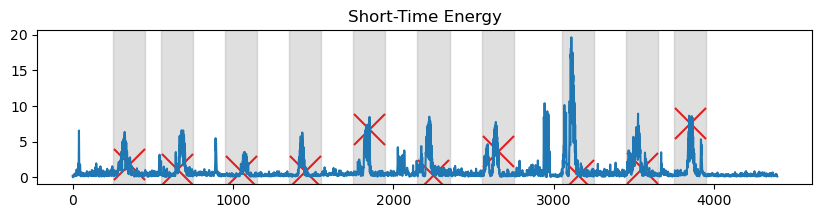

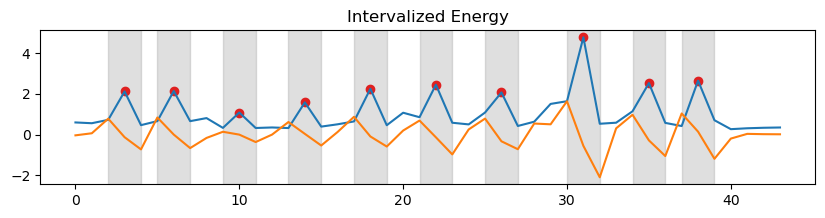

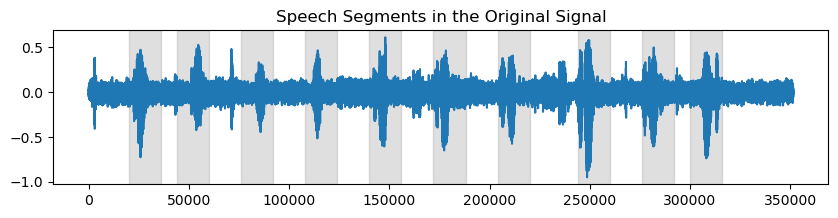

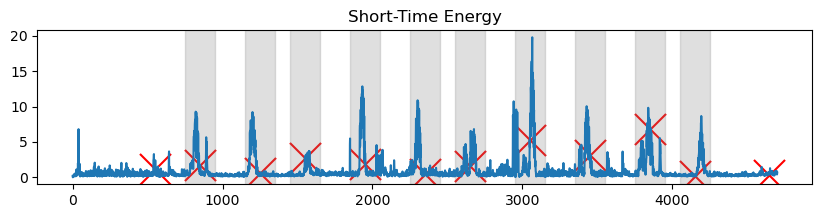

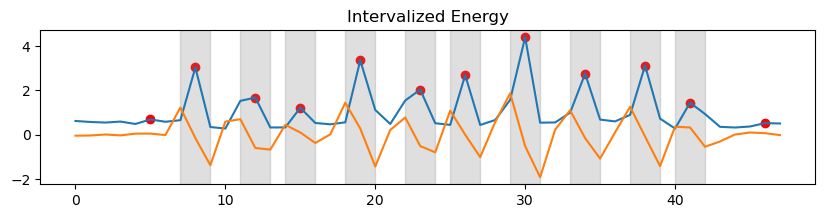

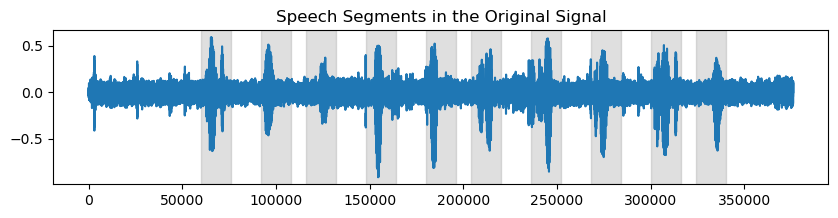

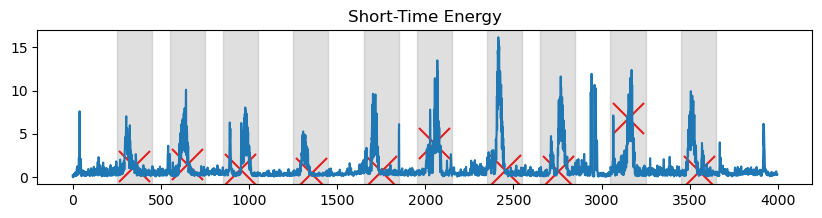

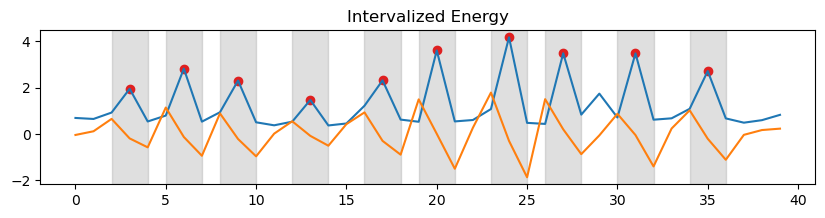

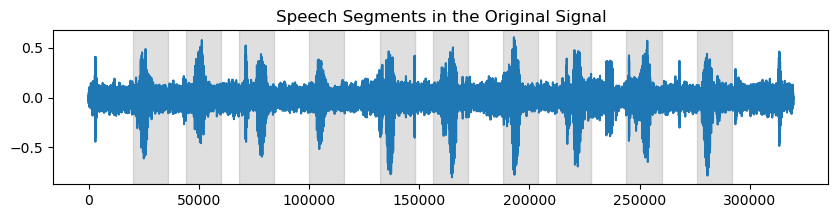

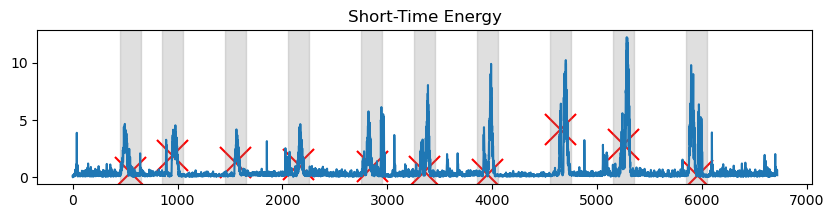

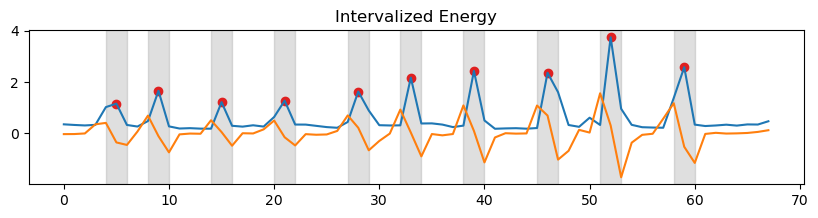

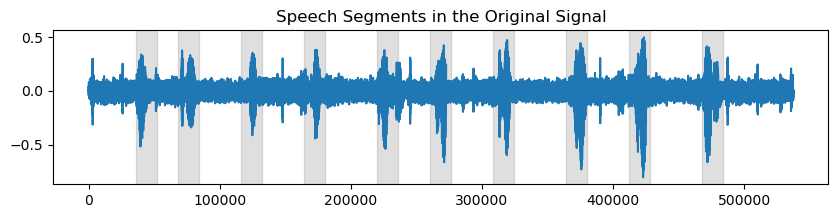

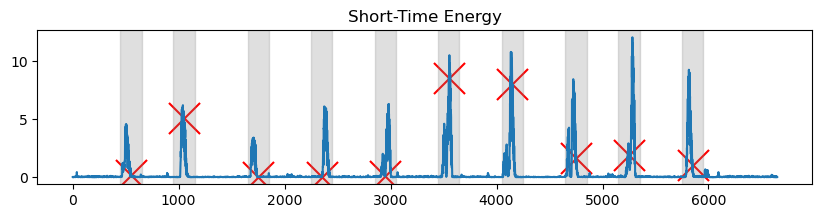

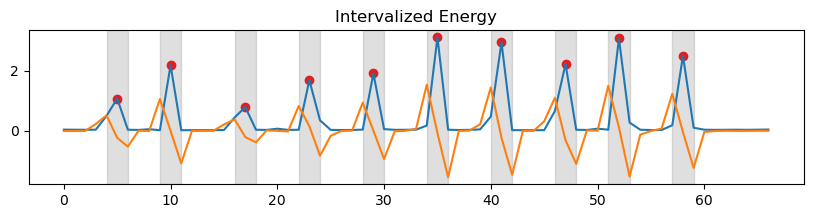

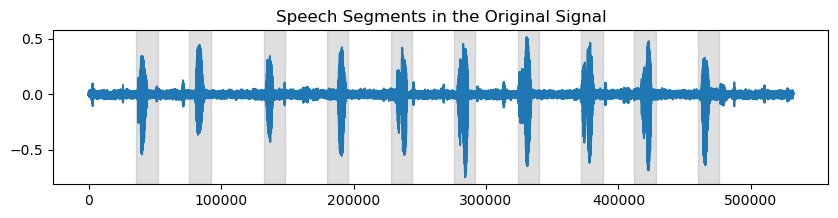

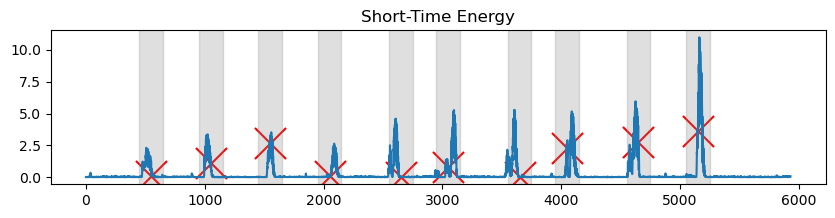

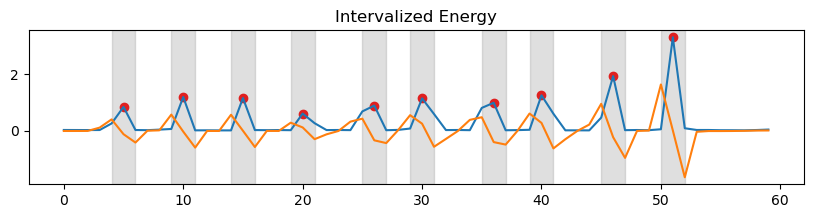

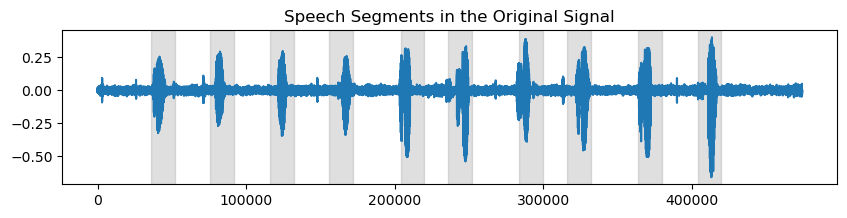

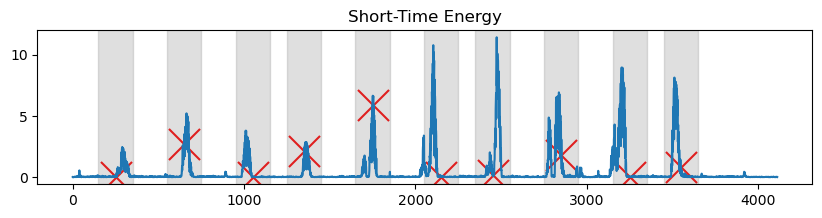

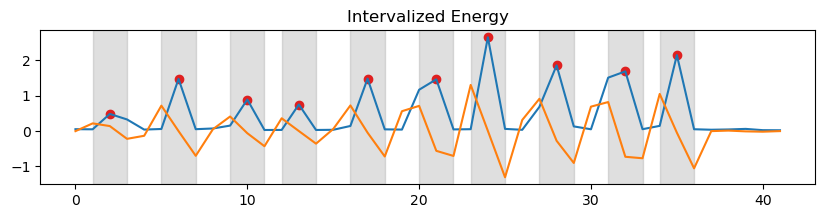

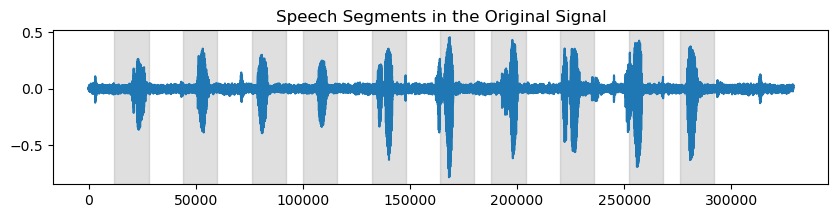

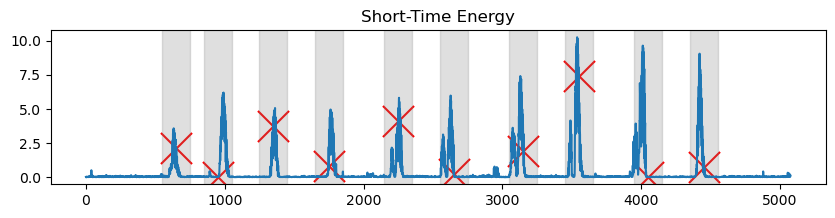

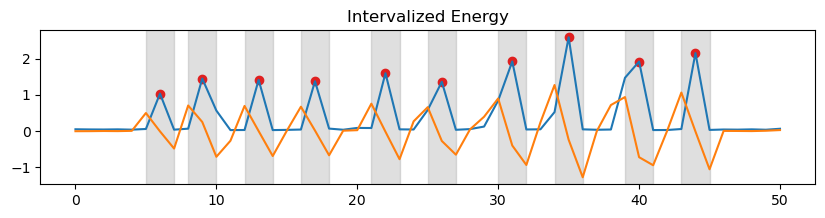

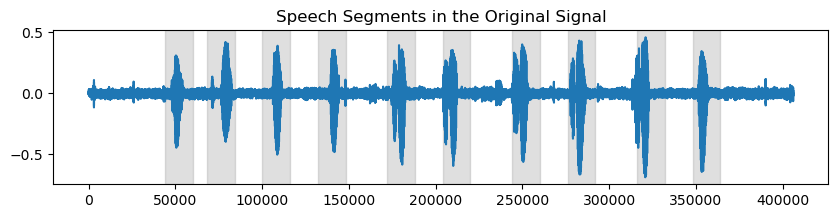

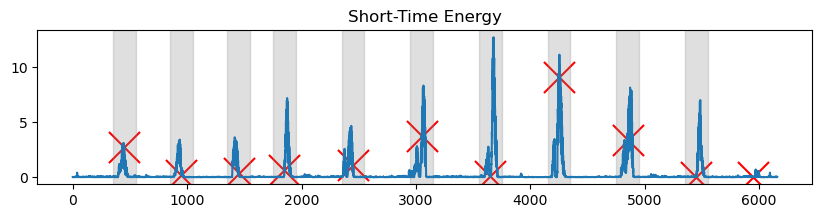

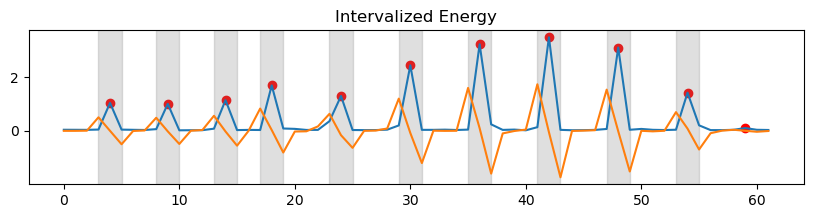

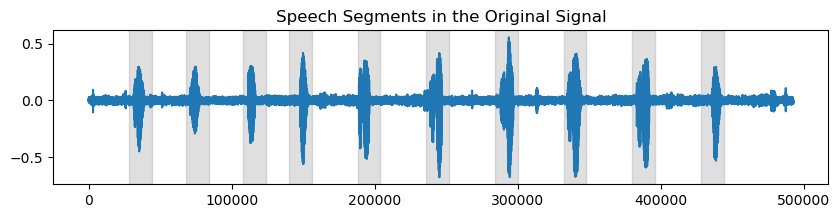

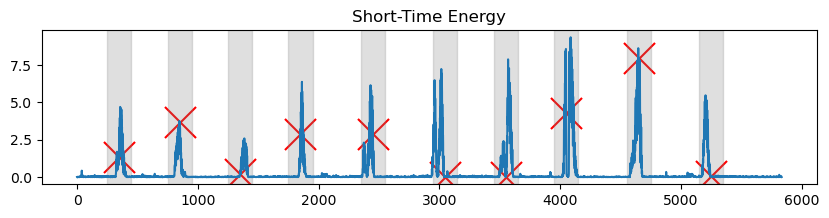

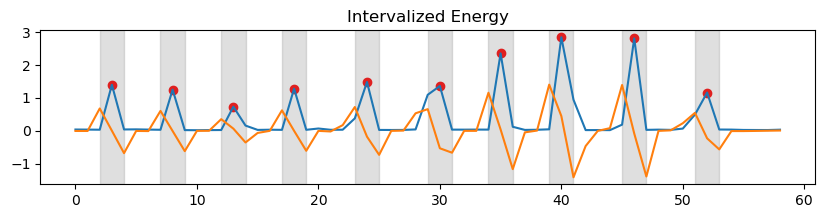

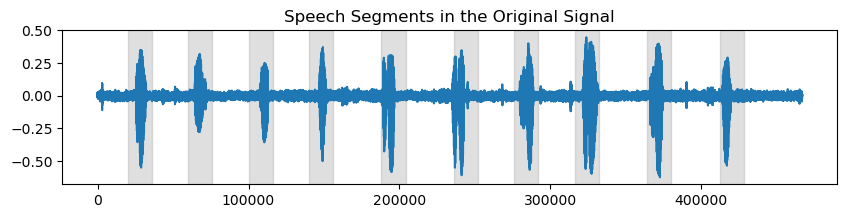

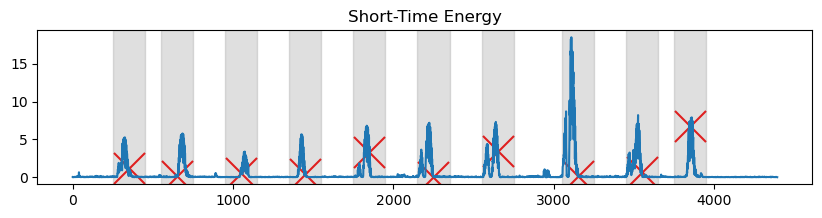

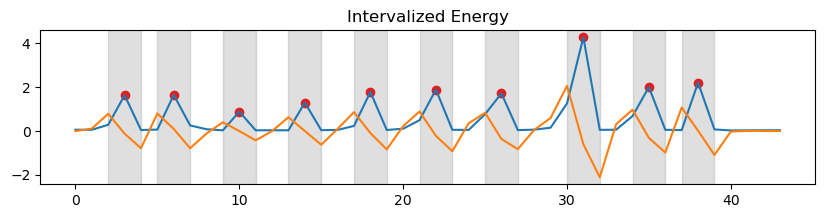

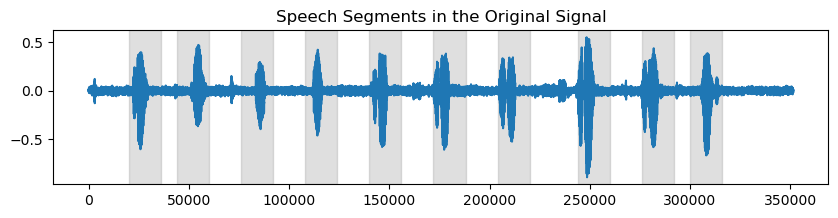

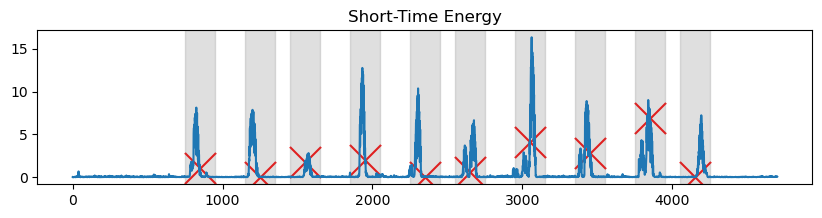

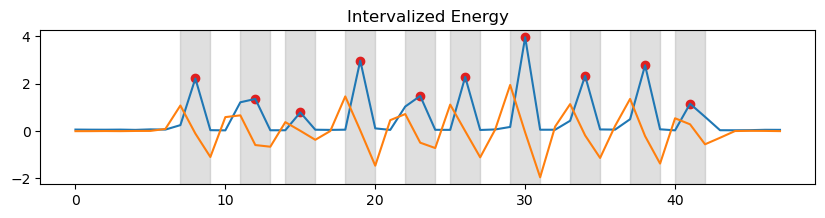

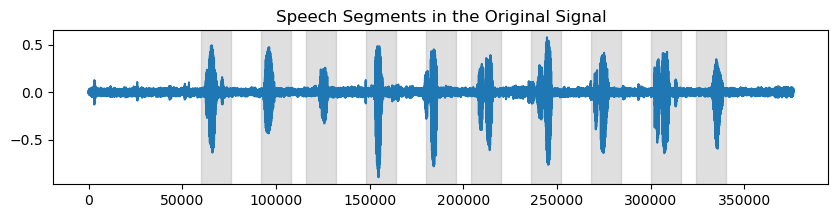

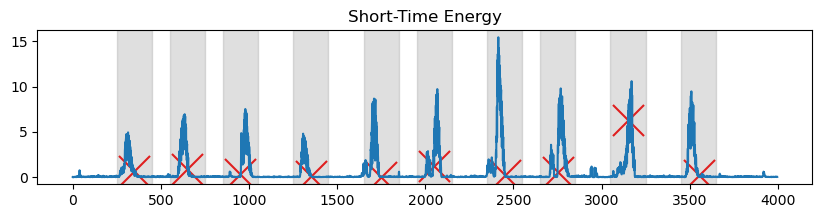

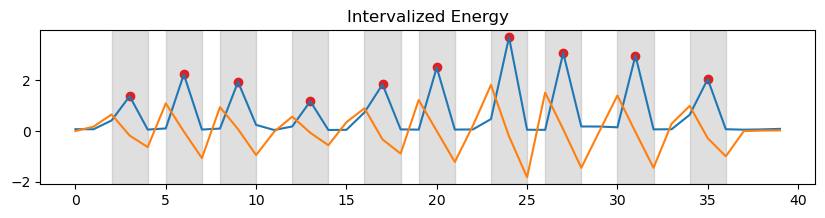

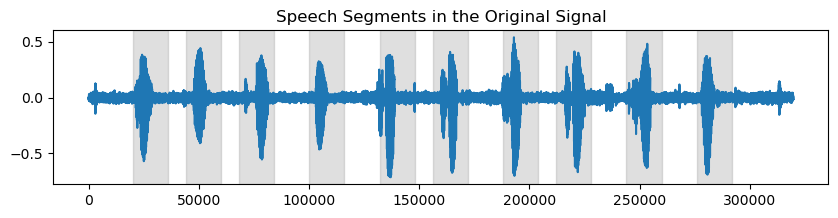

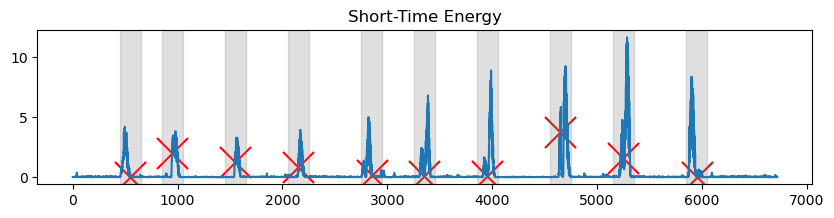

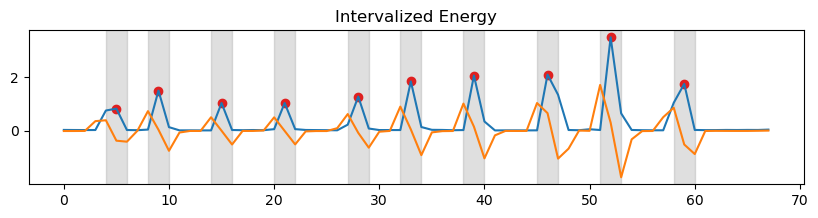

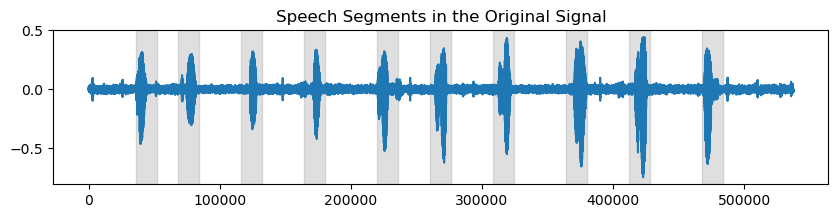

In [133]:
testfolder_list = ['./unsegmented-test/gjang/',
                   './unsegmented-test/nbnSNR-10/gjang/',
                   './unsegmented-test/nbnSNR0/gjang/',
                   './unsegmented-test/nbnSNR10/gjang/',
                   './unsegmented-test/org/gjang/',
                   './unsegmented-test/wbnSNR-10/gjang/',
                   './unsegmented-test/wbnSNR0/gjang/',
                   './unsegmented-test/wbnSNR10/gjang/']
for testfolder in testfolder_list:
    folders = os.listdir(testfolder)
    try: folders.remove('.DS_Store')
    except: pass
    for folder in folders:
        data, Fs = librosa.load(testfolder+folder)
        segments = segment(data, len_interval = 100, printout=True)
        plt.figure(figsize=(10,2))
        plt.title('Speech Segments in the Original Signal')
        plt.plot(data)
        for i in range(len(segments)):
            if i == len(segments) - 1:
                scipy.io.wavfile.write('./segmented-test/'+folder.split('.')[0]+testfolder.split('/')[2]+'-'+str(0)+'.wav', Fs, data[segments[i][0]:segments[i][1]])
            else: scipy.io.wavfile.write('./segmented-test/'+folder.split('.')[0]+testfolder.split('/')[2]+'-'+str(i+1)+'.wav', Fs, data[segments[i][0]:segments[i][1]])
            plt.axvspan(segments[i][0], segments[i][1], color='gray', alpha=0.25)
        plt.show()

##### Labeling the segmented test dataset

In [134]:
segmentedtestfiles = os.listdir('./segmented-test/')
# remove directories from list
for item in segmentedtestfiles:
    if os.path.isdir('./segmented-test/'+item):
        segmentedtestfiles.remove(item)
try: segmentedtestfiles.remove('.DS_Store')
except: pass
for item in segmentedtestfiles:
    num = item.split('-')[-1].split('.')[0]
    # move item to the correct folder
    try: shutil.move('./segmented-test/'+item, './segmented-test/gjang/'+num+'/'+item)
    except: os.remove('./segmented-test/'+item)

## III. def main():

In [135]:
def main():
    
    ### Step.1 Data Loading
    warnings.filterwarnings('ignore')
    print('Step.1 data loading...')
    print('trainDataSet loading...')
    trainDataSet = create_DataSet('./segmented-train/')
    print('validation - org loading...')
    org = create_DataSet('./segmented-val/org/')
    print('validation - nbn10 loading...')
    nbn10 = create_DataSet('./segmented-val/nbnSNR-10/')
    print('validation - nbn0 loading...')
    nbn0 = create_DataSet('./segmented-val/nbnSNR0/')
    print('validation - nbn-10 loading...')
    nbn010 = create_DataSet('./segmented-val/nbnSNR-10/')
    print('validation - wbn10 loading...')
    wbn10 = create_DataSet('./segmented-val/wbnSNR-10/')
    print('validation - wbn0 loading...')
    wbn0 = create_DataSet('./segmented-val/wbnSNR0/')
    print('validation - wbn-10 loading...')
    wbn010 = create_DataSet('./segmented-val/wbnSNR-10/')
    print('testDataSet loading...')
    testDataSet = create_DataSet('./segmented-test/')
    cleanDataSet = create_DataSet('./test-org/')
    print('Clean Data loading...')
    print("Finished preparing the data")
    
    
    ### Step.2 Training
    print('\nStep.2 Training model...')
    hmmModels = train_HMM(trainDataSet)
    
    print("Finished training the GMM_HMM models\n")
    
    ### Step.3 Evaluation
    print('predicting the train dataset...')
    predict(trainDataSet, hmmModels=hmmModels)
    print('predicting the original validation dataset...')
    predict(org, hmmModels=hmmModels)
    print('predicting the nbnSNR10 validation dataset...')
    predict(nbn10, hmmModels=hmmModels)
    print('predicting the nbnSNR0 validation dataset...')
    predict(nbn0, hmmModels=hmmModels)
    print('predicting the nbnSNR-10 validation dataset...')
    predict(nbn010, hmmModels=hmmModels)
    print('predicting the wbnSNR10 validation dataset...')
    predict(wbn10, hmmModels=hmmModels)
    print('predicting the wbnSNR0 validation dataset...')
    predict(wbn0, hmmModels=hmmModels)
    print('predicting the wbnSNR-10 validation dataset...')
    predict(wbn010, hmmModels=hmmModels)
    print('predicting the test dataset...')
    predict(testDataSet, hmmModels=hmmModels)
    print('predicting the clean dataset...')
    predict(cleanDataSet, hmmModels=hmmModels)

## IV. Run

In [152]:
if __name__ == '__main__':
    main()

Step.1 data loading...
trainDataSet loading...
validation - org loading...
validation - nbn10 loading...
validation - nbn0 loading...
validation - nbn-10 loading...
validation - wbn10 loading...
validation - wbn0 loading...
validation - wbn-10 loading...
testDataSet loading...
Clean Data loading...
Finished preparing the data

Step.2 Training model...
Finished training the GMM_HMM models

predicting the train dataset...
Accuracy:  83.623 %
predicting the original validation dataset...
Accuracy:  38.0 %
predicting the nbnSNR10 validation dataset...
Accuracy:  10.333 %
predicting the nbnSNR0 validation dataset...
Accuracy:  14.0 %
predicting the nbnSNR-10 validation dataset...
Accuracy:  10.333 %
predicting the wbnSNR10 validation dataset...
Accuracy:  10.0 %
predicting the wbnSNR0 validation dataset...
Accuracy:  9.667 %
predicting the wbnSNR-10 validation dataset...
Accuracy:  10.0 %
predicting the test dataset...
Accuracy:  25.0 %
predicting the clean dataset...
Accuracy:  43.333 %


#### Optional) RNN

In [137]:
'''
import torch
import torch.nn as nn

# train a RNN model using the datasets
# define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # forward propagate LSTM
        out, _ = self.rnn(x, h0)
        
        # decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

input_size = 20
hidden_size = 32
num_layers = 2
num_classes = 10
learning_rate = 0.001
model = RNN(input_size, hidden_size, num_layers, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
 
num_epochs = 100
train_losses = []
for epoch in range(num_epochs):
    h0 = torch.zeros(num_layers, 1, hidden_size)
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_losses.append(loss.item())
    print(f'Epoch {epoch+1}/{num_epochs}, Loss:{loss.item():.4f}')
    
plt.figure(figsize=(12,8))
plt.plot(train_losses, label='Training Loss')
plt.title('loss over epochs')
plt.legend()
plt.show()
 
h0 = torch.zeros(num_layers, 1, hidden_size)
outputs = model(X_test)
_, predicted = torch.max(outputs.data, 1)
print(f'Accuracy of the model on the test set: {100 * torch.sum(predicted == y_test) / len(y_test):.2f}%')
'''

ModuleNotFoundError: No module named 'torch'